# ÏÇ¨Ï†ÑÌïôÏäµ Î™®Îç∏Î°ú Î¶¨Î∑∞ Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú ÎßåÎì§Í∏∞

In [136]:
import os, json, re

max_len_info = 256
max_len_summary = 256
max_len_review = 128

movie_id = "mOPpNlO"
movie_folder = "./movie_data"
movie_info_path    = os.path.join(movie_folder, f"{movie_id}_info.json")
movie_reviews_path = os.path.join(movie_folder, f"{movie_id}_reviews.json")
movie_summary_path = os.path.join(movie_folder,  "movie_summary.json")

def clean_text(text):
    text = re.sub(r"[\n\r]", " ", text)
    text = re.sub(r"[^\w\sÍ∞Ä-Ìû£.,!?]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [137]:
# --- ÏòÅÌôî info ÌÖçÏä§Ìä∏ --------------------------------------------------------
with open(movie_info_path, encoding="utf-8") as f:
    info = json.load(f)

title  = info.get("ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥", {}).get("Ï†úÎ™©", "")
year   = info.get("ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥", {}).get("Í∞úÎ¥â Ïó∞ÎèÑ", "")
description = info.get("ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥", {}).get("ÏÑ§Î™Ö", "")
genre  = ", ".join(info.get("Ï∂îÍ∞Ä Ï†ïÎ≥¥", {}).get("Ïû•Î•¥", []))
director = ", ".join(info.get("Ï∂îÍ∞Ä Ï†ïÎ≥¥", {}).get("Í∞êÎèÖ", []))
actors = [
    x.get("person.name", "")
    for x in info.get("Ï∂úÏó∞/Ï†úÏûëÏßÑ Ï†ïÎ≥¥", [])
    if x.get("department") == "Î∞∞Ïö∞"
][:5]
actors = ", ".join(actors)

movie_info_text = clean_text(
    f"{genre} Ïû•Î•¥Ïùò ÏòÅÌôîÎ°ú, Í∞êÎèÖÍ≥º Ï∂úÏó∞ÏßÑÏù¥ {description}"
)[:max_len_info]

# --- Ï§ÑÍ±∞Î¶¨ ÏöîÏïΩ ------------------------------------------------------------
with open(movie_summary_path, encoding="utf-8") as f:
    summary_data = json.load(f)
summary_text = clean_text(summary_data.get(movie_id, ""))[:max_len_summary]

# --- Î¶¨Î∑∞ Î¶¨Ïä§Ìä∏ -------------------------------------------------------------
with open(movie_reviews_path, encoding="utf-8") as f:
    rv_json = json.load(f)
reviews_raw = rv_json.get("reviews", [])
reviews = [clean_text(r)[:max_len_review] for r in reviews_raw]


In [138]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

tok = T5Tokenizer.from_pretrained("KETI-AIR/ke-t5-base-ko")
model = T5ForConditionalGeneration.from_pretrained(
    "KETI-AIR/ke-t5-base-ko",
    output_attentions=True
).to(device).eval()   # Ï∂îÎ°† Î™®Îìú

/Users/youngjinson/Library/Python/3.9/lib/python/site-packages/transformers/generation/configuration_utils.py:820: UserWarning:

`return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.



In [139]:
# ================================================================
# 2. ÍµêÏ∞® Ïñ¥ÌÖêÏÖò Ï∂îÏ∂ú Ìï®Ïàò  (Î†àÏù¥Ïñ¥ 4Í∞ú ÌèâÍ∑† ‚Üí Ìó§Îìú max) -------------
# ================================================================
@torch.inference_mode()
def get_cross_attn_matrix(src_text: str, tgt_text: str,
                          n_layers: int = 10):          # ÌèâÍ∑†Ïóê Ïì∏ Î†àÏù¥Ïñ¥ Ïàò
    enc = tok(src_text, return_tensors="pt", truncation=True,
              max_length=max_len_info).to(device)
    dec = tok(tgt_text, return_tensors="pt", truncation=True,
              max_length=max_len_review).to(device)

    out = model(input_ids=enc.input_ids,
                attention_mask=enc.attention_mask,
                decoder_input_ids=dec.input_ids,
                decoder_attention_mask=dec.attention_mask,
                use_cache=False,
                output_attentions=True,
                return_dict=True)

    # 1. ÎßàÏßÄÎßâ n_layers ÍµêÏ∞® Ïñ¥ÌÖêÏÖò Ïä§ÌÉù ‚Üí ÌèâÍ∑†
    layers = out.cross_attentions[-n_layers:]       # list[tensor(B, head, tgt, src)]
    cross = torch.stack(layers).mean(0)             # [B, head, tgt, src]

    # 2. Ìó§Îìú Ï∞®ÏõêÏóêÏÑú max ‚Äì ÏùòÎØ∏Í∞Ä Í∞ïÌïòÍ≤å Î™∞Î¶∞ Ï™ΩÎßå ÎÇ®ÍπÄ
    cross = cross.max(dim=1).values.squeeze(0)      # [tgt, src]

    x_tokens = tok.convert_ids_to_tokens(enc.input_ids[0])
    y_tokens = tok.convert_ids_to_tokens(dec.input_ids[0])
    return cross.cpu(), x_tokens, y_tokens

In [140]:
def zero_special(mat, src_tokens, tgt_tokens):
    for i, tok in enumerate(src_tokens):
        if tok in SPECIAL:
            mat[:, i] = 0               # Ïó¥ 0
    for j, tok in enumerate(tgt_tokens):
        if tok in SPECIAL:
            mat[j, :] = 0               # Ìñâ 0
    return mat

In [141]:
# ================================================================
# 3. ÏãúÍ∞ÅÌôî Ìï®Ïàò (matplotlib) --------------------------------------
# ================================================================
import numpy as np
import matplotlib.pyplot as plt

def plot_cross_heatmap(mat, x_tokens, y_tokens, title="Cross attention"):
    fig, ax = plt.subplots(figsize=(len(x_tokens)*0.3+3, len(y_tokens)*0.3+3))
    im = ax.imshow(mat, aspect="auto")
    ax.set_xticks(np.arange(len(x_tokens)))
    ax.set_yticks(np.arange(len(y_tokens)))
    ax.set_xticklabels(x_tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(y_tokens, fontsize=8)
    ax.set_xlabel("Source tokens")
    ax.set_ylabel("Target tokens (review)")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.015)
    fig.tight_layout()
    plt.show()

def plot_aggregated_bar(attn_mats, x_tokens, title="Aggregated attention"):
    # attn_mats: list of np.array [tgt_len, src_len]
    summed = np.sum([m.sum(axis=0) for m in attn_mats], axis=0)
    summed = summed / summed.sum()
    plt.figure(figsize=(len(x_tokens)*0.3+3, 4))
    plt.bar(range(len(x_tokens)), summed)
    plt.xticks(range(len(x_tokens)), x_tokens, rotation=90, fontsize=8)
    plt.ylabel("Normalized weight")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [142]:
def sp_pieces_to_words(tokens):
    words, idx_groups = [], []
    cur_tok, cur_idx = [], []
    for i, tok in enumerate(tokens):
        if tok.startswith("‚ñÅ") and cur_tok:    # ÏÉà Îã®Ïñ¥ ÏãúÏûë
            words.append("".join(t.lstrip("‚ñÅ") for t in cur_tok))
            idx_groups.append(cur_idx)
            cur_tok, cur_idx = [tok], [i]
        else:
            cur_tok.append(tok)
            cur_idx.append(i)
    # ÎßàÏßÄÎßâ Îã®Ïñ¥
    if cur_tok:
        words.append("".join(t.lstrip("‚ñÅ") for t in cur_tok))
        idx_groups.append(cur_idx)
    return words, idx_groups


# stop_words ÏÑ∏Ìä∏Ïóê ÎπºÍ≥† Ïã∂ÏùÄ Îã®Ïñ¥ Ï∂îÍ∞Ä
stop_words = {"ÏòÅÌôî", "Ï§ÑÍ±∞Î¶¨", "</s>",'ÎÇú','Ìï©ÎãàÎã§.'}

def aggregate_cross_attention(mat, src_toks, tgt_toks):
    src_words, src_grp = sp_pieces_to_words(src_toks)
    tgt_words, tgt_grp = sp_pieces_to_words(tgt_toks)

    # --- Î∂àÏö©Ïñ¥ ÌïÑÌÑ∞ Ï†ÅÏö© -----------------------------------------
    filtered = [(w, g) for w, g in zip(src_words, src_grp) if w not in stop_words]
    if not filtered:
        return np.zeros((len(tgt_words), 1)), ["<filtered>"], tgt_words
    src_words, src_grp = zip(*filtered)             # unzip
    # --------------------------------------------------------------

    src_len, tgt_len = mat.shape[1], mat.shape[0]
    word_mat = np.zeros((len(tgt_words), len(src_words)))
    for ti, tg in enumerate(tgt_grp):
        tg = [idx for idx in tg if idx < tgt_len]
        if not tg:
            continue
        for si, sg in enumerate(src_grp):
            sg = [idx for idx in sg if idx < src_len]
            if sg:
                word_mat[ti, si] = mat[np.ix_(tg, sg)].mean()
    return word_mat, list(src_words), tgt_words

In [143]:
SPECIAL = {"</s>", "<pad>", "<unk>"}

def drop_special(mat, src_tokens, tgt_tokens):
    # Ïó¥(Ï†ïÎ≥¥ Ï™Ω) ÌïÑÌÑ∞
    src_keep = [i for i, t in enumerate(src_tokens) if t not in SPECIAL]
    # Ìñâ(Î¶¨Î∑∞ Ï™Ω) ÌïÑÌÑ∞
    tgt_keep = [i for i, t in enumerate(tgt_tokens) if t not in SPECIAL]
    mat = mat[np.ix_(tgt_keep, src_keep)]
    src_tokens = [src_tokens[i] for i in src_keep]
    tgt_tokens = [tgt_tokens[i] for i in tgt_keep]
    return mat, src_tokens, tgt_tokens

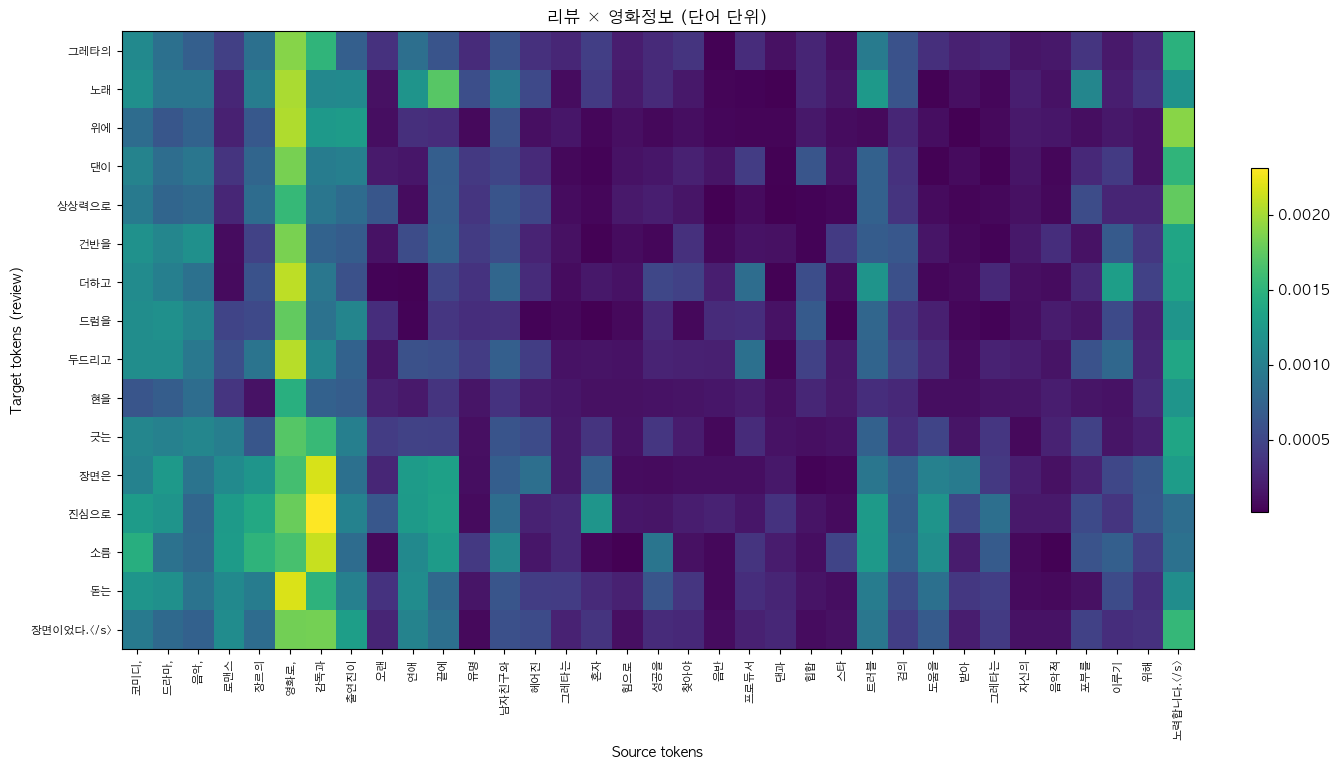

In [144]:
# ================================================================
# 4. ÏòàÏãú Ïã§Ìñâ ------------------------------------------------------
# ================================================================
# 4-1. Î¶¨Î∑∞ 1Í±¥ √ó ÏòÅÌôî Ï†ïÎ≥¥ -----------------------------------------
rv_sample = reviews[4] if reviews else "Î¶¨Î∑∞ ÏóÜÏùå"

cross, src_tok, tgt_tok = get_cross_attn_matrix(movie_info_text, rv_sample)
cross = cross / (cross.sum() + 1e-9)

word_mat, src_words, tgt_words = aggregate_cross_attention(
    cross.numpy(), src_tok, tgt_tok)

plot_cross_heatmap(word_mat, src_words, tgt_words,
                   title="Î¶¨Î∑∞ √ó ÏòÅÌôîÏ†ïÎ≥¥ (Îã®Ïñ¥ Îã®ÏúÑ)")

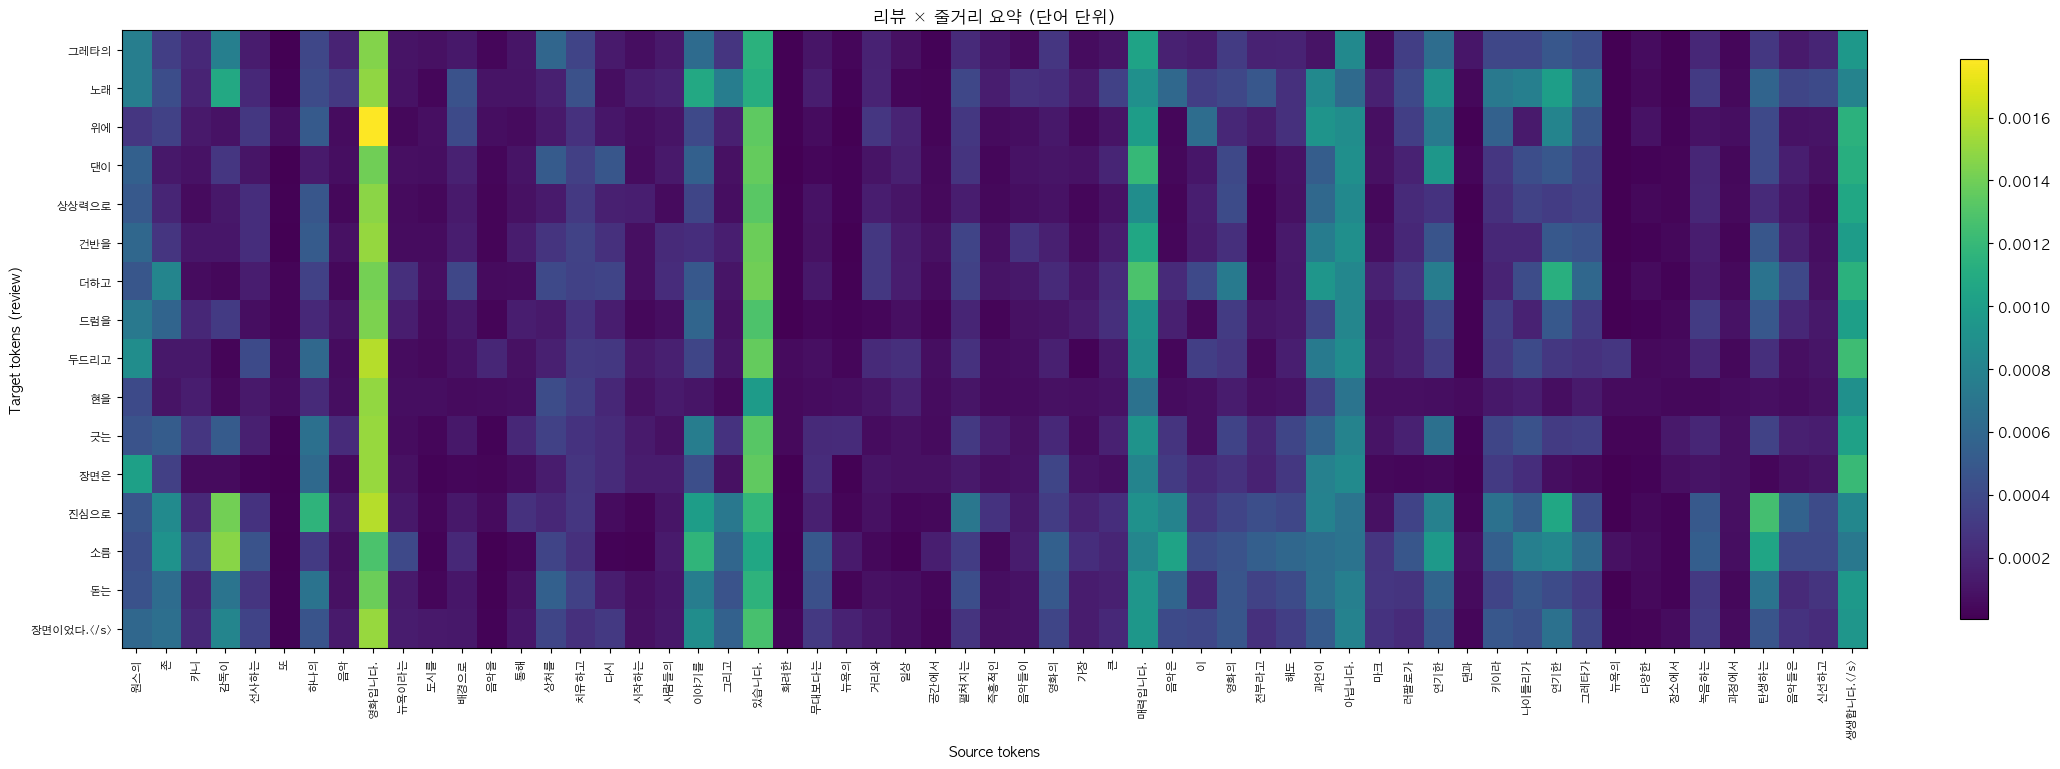

In [145]:
# 4-2. Î¶¨Î∑∞ Ìïú Í±¥ √ó Ï§ÑÍ±∞Î¶¨ ÏöîÏïΩ  (Îã®Ïñ¥ Îã®ÏúÑ)  << ÎèôÏùº Î∞©Ïãù
cross2, src_tok2, _ = get_cross_attn_matrix(summary_text, rv_sample)
cross2 = cross2 / (cross2.sum() + 1e-9)

word_mat2, src_words2, _ = aggregate_cross_attention(
    cross2.numpy(), src_tok2, tgt_tok)

plot_cross_heatmap(word_mat2, src_words2, tgt_words,
                   title="Î¶¨Î∑∞ √ó Ï§ÑÍ±∞Î¶¨ ÏöîÏïΩ (Îã®Ïñ¥ Îã®ÏúÑ)")

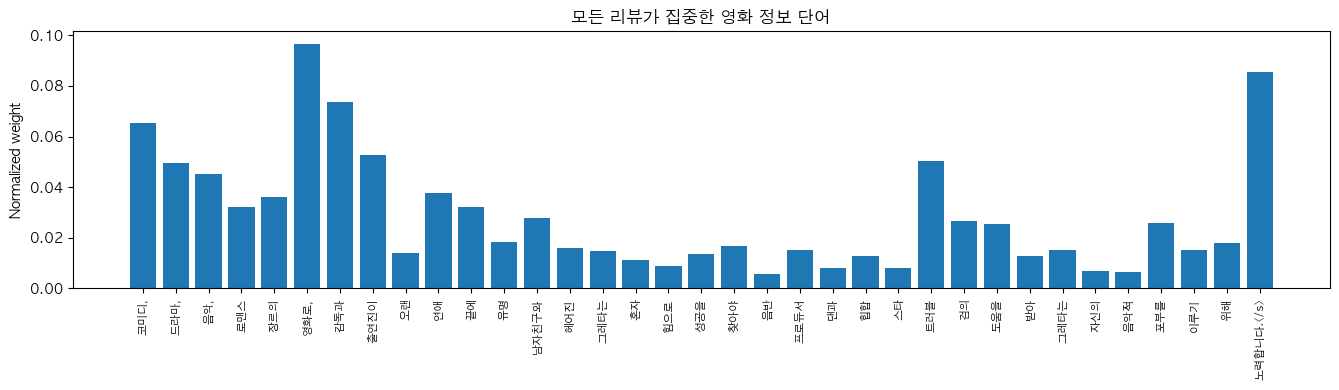

In [146]:
# 4-3. Î™®Îì† Î¶¨Î∑∞ ÏßëÍ≥Ñ  (ÏòÅÌôî Ï†ïÎ≥¥ Í∏∞Ï§Ä, Îã®Ïñ¥ Îã®ÏúÑ)  << ÏàòÏ†ï
all_word_mats = []
for rv in reviews[:300]:                                   # 50Í∞ú ÏÉòÌîå
    c, s_tok, _ = get_cross_attn_matrix(movie_info_text, rv)
    c = c / (c.sum() + 1e-9)

    wm, _, _ = aggregate_cross_attention(c.numpy(), s_tok, tgt_tok)
    all_word_mats.append(wm)

plot_aggregated_bar(all_word_mats, src_words,
                    title="Î™®Îì† Î¶¨Î∑∞Í∞Ä ÏßëÏ§ëÌïú ÏòÅÌôî Ï†ïÎ≥¥ Îã®Ïñ¥")

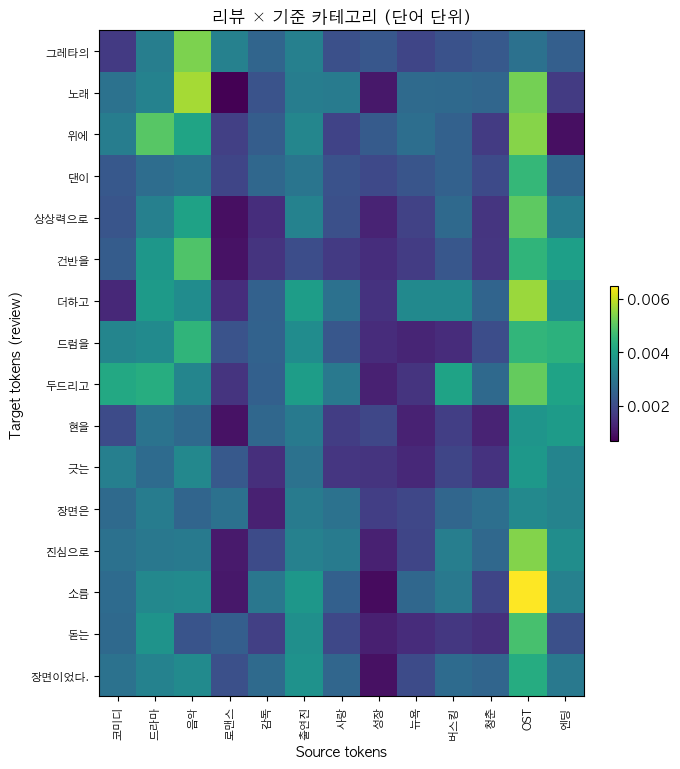

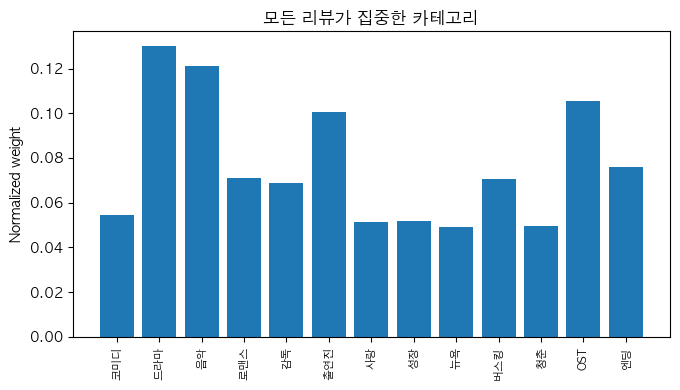

In [147]:
# ---------------------------------------------------------------
# ÏÉà Í∏∞Ï§Ä Î¨∏Ïû• Ï†ïÏùò ---------------------------------------------
# ---------------------------------------------------------------
criteria_text = (
    "ÏΩîÎØ∏Îîî ÎìúÎùºÎßà ÏùåÏïÖ Î°úÎß®Ïä§ Í∞êÎèÖ Ï∂úÏó∞ÏßÑ "
    "ÏÇ¨Îûë ÏÑ±Ïû• Îâ¥Ïöï Î≤ÑÏä§ÌÇπ Ï≤≠Ï∂ò OST ÏóîÎî©"
)

# 1) Î¶¨Î∑∞ ÌïòÎÇòÏôÄ ÍµêÏ∞® Ïñ¥ÌÖêÏÖò ------------------------------------
cross_c, x_tok_c, y_tok_c = get_cross_attn_matrix(criteria_text, rv_sample)

# torch.Tensor ‚Üí NumPy (Îî± Ìïú Î≤à)
cross_c = cross_c.numpy()

# ÌäπÏàò ÌÜ†ÌÅ∞ Ïó¥¬∑Ìñâ Ï†úÍ±∞
cross_c, x_tok_c, y_tok_c = drop_special(cross_c, x_tok_c, y_tok_c)

# Ï†ïÍ∑úÌôî
cross_c = cross_c / (cross_c.sum() + 1e-9)

# Îã®Ïñ¥ ÏßëÍ≥Ñ + ÏãúÍ∞ÅÌôî
word_mat_c, src_words_c, tgt_words_c = aggregate_cross_attention(
    cross_c, x_tok_c, y_tok_c)

plot_cross_heatmap(word_mat_c, src_words_c, tgt_words_c,
                   title="Î¶¨Î∑∞ √ó Í∏∞Ï§Ä Ïπ¥ÌÖåÍ≥†Î¶¨ (Îã®Ïñ¥ Îã®ÏúÑ)")


# 2) Ïó¨Îü¨ Î¶¨Î∑∞ ÏßëÍ≥Ñ ---------------------------------------------
all_mats_c = []
for rv in reviews[:100]:
    mat_c, x_tok_cur, y_tok_cur = get_cross_attn_matrix(criteria_text, rv)
    mat_c = mat_c.numpy()                          # Ìïú Î≤àÎßå Î≥ÄÌôò
    mat_c, x_tok_cur, y_tok_cur = drop_special(mat_c, x_tok_cur, y_tok_cur)
    mat_c = mat_c / (mat_c.sum() + 1e-9)

    wm_c, _, _ = aggregate_cross_attention(mat_c, x_tok_cur, y_tok_cur)
    all_mats_c.append(wm_c)

plot_aggregated_bar(all_mats_c, src_words_c,
                    title="Î™®Îì† Î¶¨Î∑∞Í∞Ä ÏßëÏ§ëÌïú Ïπ¥ÌÖåÍ≥†Î¶¨")

---

Ollama Î°ú criteria text ÏÉùÏÑ±ÌïòÍ∏∞

In [148]:
import os, json, re, numpy as np, plotly.express as px


In [149]:
#!pip3 install plotly

In [ ]:
# -*- coding: utf-8 -*-
"""
run_cross_attention.py
 - movie_data/
     ‚îú‚îÄ mOPpNlO_info.json
     ‚îú‚îÄ mOPpNlO_reviews.json
     ‚îú‚îÄ mOPpNlO_criteria.json   # {"mOPpNlO": "ÏΩîÎØ∏Îîî ‚Ä¶ ÏóîÎî©"}
     ‚îî‚îÄ movie_summary.json
 - attn/        (ÏûêÎèô ÏÉùÏÑ±)
 - viz/         (ÏûêÎèô ÏÉùÏÑ±)
ÌïÑÏàò pip: transformers[sentencepiece] torch plotly
"""

import os, json, re, numpy as np, plotly.express as px
from tqdm import tqdm
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# ---------- Í≥µÌÜµ ÌååÎùºÎØ∏ÌÑ∞ -------------------------------------------------
MAX_INFO, MAX_SUM, MAX_REV = 256, 256, 128
MOVIE_DIR   = "./movie_data"
ATTN_DIR    = "./attn"
VIZ_DIR     = "./viz"
os.makedirs(ATTN_DIR, exist_ok=True)
os.makedirs(VIZ_DIR,  exist_ok=True)

# ---------- util ----------------------------------------------------------
def clean(text):
    text = re.sub(r"[\n\r]", " ", text)
    text = re.sub(r"[^\w\sÍ∞Ä-Ìû£.,!?]", "", text)
    return re.sub(r"\s+", " ", text).strip()

SPECIAL = {"</s>", "<pad>", "<unk>"}
def drop_special(mat, xs, ys):
    col_keep = [i for i, t in enumerate(xs) if t not in SPECIAL]
    row_keep = [i for i, t in enumerate(ys) if t not in SPECIAL]
    return mat[np.ix_(row_keep, col_keep)], [xs[i] for i in col_keep], [ys[i] for i in row_keep]

def sp_pieces_to_words(tokens):
    words, groups, cur, idxs = [], [], [], []
    for i, tok in enumerate(tokens):
        if tok.startswith("‚ñÅ") and cur:
            words.append("".join(t.lstrip("‚ñÅ") for t in cur)); groups.append(idxs)
            cur, idxs = [tok], [i]
        else:
            cur.append(tok); idxs.append(i)
    if cur:
        words.append("".join(t.lstrip("‚ñÅ") for t in cur)); groups.append(idxs)
    return words, groups

def agg_cross(mat, xs, ys):
    sw, sg = sp_pieces_to_words(xs)
    tw, tg = sp_pieces_to_words(ys)
    wmat = np.zeros((len(tw), len(sw)))
    s_len, t_len = mat.shape[1], mat.shape[0]
    for ti, tg_idx in enumerate(tg):
        tg_idx = [i for i in tg_idx if i < t_len]
        for si, sg_idx in enumerate(sg):
            sg_idx = [i for i in sg_idx if i < s_len]
            if tg_idx and sg_idx:
                wmat[ti, si] = mat[np.ix_(tg_idx, sg_idx)].mean()
    return wmat, sw, tw

# ---------- Î™®Îç∏ Î°úÎìú -----------------------------------------------------
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
tok = T5Tokenizer.from_pretrained("KETI-AIR/ke-t5-base-ko")
model = T5ForConditionalGeneration.from_pretrained(
    "KETI-AIR/ke-t5-base-ko", output_attentions=True).to(device).eval()

@torch.inference_mode()
def cross_attn(src, tgt):
    enc = tok(src, return_tensors="pt", truncation=True, max_length=MAX_INFO).to(device)
    dec = tok(tgt, return_tensors="pt", truncation=True, max_length=MAX_REV ).to(device)
    out = model(input_ids=enc.input_ids,
                attention_mask=enc.attention_mask,
                decoder_input_ids=dec.input_ids,
                decoder_attention_mask=dec.attention_mask,
                use_cache=False, output_attentions=True, return_dict=True)
    layers = out.cross_attentions[-4:]
    cross = torch.stack(layers).mean(0).max(dim=1).values.squeeze(0)
    return cross.cpu().numpy(), tok.convert_ids_to_tokens(enc.input_ids[0]), tok.convert_ids_to_tokens(dec.input_ids[0])

# ---------- ÏòÅÌôî ID Î™©Î°ù ---------------------------------------------------
movie_ids = [f.split("_")[0] for f in os.listdir(MOVIE_DIR) if f.endswith("_info.json")]

# ---------- Î©îÏù∏ Î£®ÌîÑ ------------------------------------------------------
for mid in tqdm(movie_ids, desc="processing"):
    # 1. Í∏∞Ï§Ä Î¨∏Ïû• Î°úÎìú
    crit_path = os.path.join(MOVIE_DIR, f"{mid}_criteria.json")
    if not os.path.exists(crit_path):
        print(f"[skip] {mid}: criteria json not found"); continue
    criteria = clean(json.load(open(crit_path, encoding="utf8"))[mid])

    # 2. Î¶¨Î∑∞ Î°úÎìú
    reviews = json.load(open(os.path.join(MOVIE_DIR, f"{mid}_reviews.json"), encoding="utf8"))["reviews"]
    reviews = [clean(r)[:MAX_REV] for r in reviews]

   # 3. Î™®Îì† Î¶¨Î∑∞ ÏßëÍ≥Ñ ----------------------------------------------
    master_sw = None
    all_vec = []                       # 1-D Î≤°ÌÑ∞Îì§Îßå Ï†ÄÏû•

    for rv in reviews[:200]:
        mat, xs, ys = cross_attn(criteria, rv)
        mat, xs, ys = drop_special(mat, xs, ys)
        mat = mat / (mat.sum() + 1e-9)
        wm, sw, _ = agg_cross(mat, xs, ys)

        # ----- Ïó¥ ÎßûÏ∂îÍ∏∞ (Ïù¥Ï†ÑÍ≥º ÎèôÏùº) ------------------------------
        if master_sw is None:
            master_sw = sw
            aligned = wm
        else:
            aligned = np.zeros((wm.shape[0], len(master_sw)))
            col_map = {w: i for i, w in enumerate(sw)}
            for j, token in enumerate(master_sw):
                if token in col_map:
                    aligned[:, j] = wm[:, col_map[token]]
        # -----------------------------------------------------------

        vec = aligned.sum(axis=0)      # ‚òÖ Ìñâ Ìï© ‚Üí (len(master_sw),)
        all_vec.append(vec)

    # shape ÎèôÏùºÌïú 1-D Î≤°ÌÑ∞Îì§Ïùò Ìï©
    agg = np.sum(all_vec, axis=0)      # (len(master_sw),)
    # 4. Ï†ÄÏû•
    np.save(f"{ATTN_DIR}/{mid}_criteria.npy", agg)
    with open(f"{ATTN_DIR}/{mid}_tokens.json", "w", encoding="utf8") as f:
        json.dump({"src": master_sw}, f, ensure_ascii=False)

    # 5. Plotly (Í∞ÄÎ°ú ÎßâÎåÄÎÇò heatmap 1Ìñâ)
    fig = px.bar(x=master_sw, y=np.sqrt(agg),
                labels=dict(x="Ïπ¥ÌÖåÍ≥†Î¶¨", y="sqrt-weight"),
                title=f"{mid} ‚Äì Í∏∞Ï§Ä Ïπ¥ÌÖåÍ≥†Î¶¨ ÏßëÍ≥Ñ")
    fig.update_layout(xaxis_tickangle=45)
    fig.write_html(f"{VIZ_DIR}/{mid}_criteria.html", include_plotlyjs="cdn")

print("ÏôÑÎ£å ‚Äì viz/ Ìè¥ÎçîÏóê HTMLÏù¥ ÏÉùÏÑ±ÎêêÏäµÎãàÎã§.")

# ÎåÄÏãúÎ≥¥Îìú ÎßåÎì§Í∏∞

In [ ]:
!pip3 install dash dash-bootstrap-components jupyter_dash

In [7]:
# build_attn_cache.py
import os, json, re, numpy as np, torch
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration

MOVIE_DIR = "./movie_data"
CACHE_DIR = "./attn_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

MAX_INFO, MAX_REV = 256, 128
N_HMAP = 150    # Î¶¨Î∑∞ 30Í∞úÍπåÏßÄÎßå ÌûàÌä∏Îßµ Ï†ÄÏû•
device = torch.device("cpu")  # GPU ÏóÜÏù¥ CPU Î™®Îìú

# ‚îÄ‚îÄ ‚ë† ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä/Î™®Îç∏ Î°úÎìú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
tokenizer = T5Tokenizer.from_pretrained("KETI-AIR/ke-t5-base-ko")
model     = T5ForConditionalGeneration.from_pretrained(
    "KETI-AIR/ke-t5-base-ko", output_attentions=True
).to(device).eval()

SPECIAL = {"</s>", "<pad>", "<unk>"}
clean = lambda s: re.sub(r"\s+", " ",
                re.sub(r"[^\w\sÍ∞Ä-Ìû£.,!?]", " ", s)).strip()

# ‚îÄ‚îÄ ‚ë° cross-attention Ï∂îÏ∂ú (ÏÑúÎ∏åÏõåÎìú Îã®ÏúÑ) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
@torch.inference_mode()
def cross_matrix(criteria: str, review: str):
    # ÌÜ†ÌÅ∞Ìôî ÌõÑ ÌÖêÏÑúÎßå device Î°ú ÏòÆÍ∏∞Í∏∞
    enc = tokenizer(criteria,
                    return_tensors="pt",
                    truncation=True,
                    max_length=MAX_INFO)
    dec = tokenizer(review,
                    return_tensors="pt",
                    truncation=True,
                    max_length=MAX_REV)
    enc = {k: v.to(device) for k,v in enc.items()}
    dec = {k: v.to(device) for k,v in dec.items()}

    out = model(input_ids=enc["input_ids"],
                attention_mask=enc["attention_mask"],
                decoder_input_ids=dec["input_ids"],
                decoder_attention_mask=dec["attention_mask"],
                output_attentions=True,
                return_dict=True)

    # ÎßàÏßÄÎßâ 10Ï∏µ ÌèâÍ∑† ‚Üí head-max ‚Üí [tgt,src] Tensor
    layers = out.cross_attentions[-10:]
    cross = torch.stack(layers).mean(0).max(dim=1).values[0]

    # ÌÜ†ÌÅ∞ Î¶¨Ïä§Ìä∏ (ÏÑúÎ∏åÏõåÎìú)
    xs = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
    ys = tokenizer.convert_ids_to_tokens(dec["input_ids"][0])

    # ÌäπÏàòÌÜ†ÌÅ∞ Ï†úÍ±∞
    keep_x = [i for i,t in enumerate(xs) if t not in SPECIAL]
    keep_y = [i for i,t in enumerate(ys) if t not in SPECIAL]
    xs = [xs[i] for i in keep_x]
    ys = [ys[i] for i in keep_y]
    mat = cross.cpu().numpy()[np.ix_(keep_y, keep_x)]

    # Ï†ÑÏ≤¥ Ìï© Ï†ïÍ∑úÌôî
    mat = mat / (mat.sum() + 1e-9)
    return mat, xs, ys

# ‚îÄ‚îÄ ‚ë¢ ÏÑúÎ∏åÏõåÎìú‚ÜíÎã®Ïñ¥ ÏßëÍ≥Ñ Ìï®Ïàò (Í∏∞Ï°¥ Í∑∏ÎåÄÎ°ú) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def sp_pieces_to_words(tokens):
    words, groups, cur, idxs = [], [], [], []
    for i, t in enumerate(tokens):
        if t.startswith("‚ñÅ") and cur:
            words.append("".join(x.lstrip("‚ñÅ") for x in cur)); groups.append(idxs)
            cur, idxs = [t], [i]
        else:
            cur.append(t); idxs.append(i)
    if cur:
        words.append("".join(x.lstrip("‚ñÅ") for x in cur)); groups.append(idxs)
    return words, groups

stop_words = {"ÏòÅÌôî", "Ï§ÑÍ±∞Î¶¨", "</s>", "<pad>"}
def aggregate_cross_attention(mat, src_toks, tgt_toks):
    src_words, src_grp = sp_pieces_to_words(src_toks)
    tgt_words, tgt_grp = sp_pieces_to_words(tgt_toks)

    # Î∂àÏö©Ïñ¥ ÌïÑÌÑ∞
    filtered = [(w,g) for w,g in zip(src_words, src_grp) if w not in stop_words]
    if not filtered:
        return np.zeros((len(tgt_words),1)), ["<filtered>"], tgt_words
    src_words, src_grp = zip(*filtered)

    tgt_len, src_len = mat.shape
    wmat = np.zeros((len(tgt_words), len(src_words)))
    for ti, tg in enumerate(tgt_grp):
        tg = [i for i in tg if i < tgt_len]
        for si, sg in enumerate(src_grp):
            sg = [i for i in sg if i < src_len]
            if tg and sg:
                wmat[ti,si] = mat[np.ix_(tg,sg)].mean()
    return wmat, list(src_words), tgt_words

# ‚îÄ‚îÄ ‚ë£ Ï∫êÏãú ÎπåÎìú Î£®ÌîÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
for fn in tqdm(os.listdir(MOVIE_DIR)):
    if not fn.endswith("_criteria.json"):
        continue
    mid = fn.split("_")[0]
    vec_path  = f"{CACHE_DIR}/{mid}_vec.npy"
    tok_path  = f"{CACHE_DIR}/{mid}_tok.json"
    hmap_path = f"{CACHE_DIR}/{mid}_hmap.npz"

    if os.path.exists(vec_path):
        continue   # Ïù¥ÎØ∏ Ï≤òÎ¶¨Îê®

    criteria = clean(json.load(open(f"{MOVIE_DIR}/{mid}_criteria.json","r",encoding="utf8"))[mid])
    reviews  = json.load(open(f"{MOVIE_DIR}/{mid}_reviews.json","r",encoding="utf8"))["reviews"]

    master_sw, agg_vec = None, None
    heatmaps, hmap_ys  = [], []

    for idx, rv in enumerate(reviews[:N_HMAP]):
        rv = clean(rv)[:MAX_REV]
        mat, xs, ys = cross_matrix(criteria, rv)
        wmat, sw, tw = aggregate_cross_attention(mat, xs, ys)

        # Ï≤´ Î¶¨Î∑∞ÏóêÏÑú Îã®Ïñ¥ ÏàúÏÑú Ï¥àÍ∏∞Ìôî
        if master_sw is None:
            master_sw, agg_vec = sw, wmat.sum(axis=0)
        else:
            aligned = np.zeros(len(master_sw))
            idx_map = {w:i for i,w in enumerate(sw)}
            for i, w in enumerate(master_sw):
                if w in idx_map:
                    aligned[i] = wmat.sum(axis=0)[ idx_map[w] ]
            agg_vec += aligned

        heatmaps.append(wmat)
        hmap_ys.append(tw)

    # Ï†ÄÏû•: aggregate vector + ÌÜ†ÌÅ∞ ÏàúÏÑú
    np.save(vec_path, agg_vec)
    with open(tok_path, "w", encoding="utf8") as f:
        json.dump({"tokens": master_sw}, f, ensure_ascii=False)

    # Ï†ÄÏû•: word-level ÌûàÌä∏Îßµ NÍ∞ú + tgt tokens
    np.savez_compressed(
        hmap_path,
        mats=np.array(heatmaps, dtype=object),
        ys =np.array(hmap_ys,   dtype=object)
    )

print("‚úÖ attention+heatmap Ï∫êÏãú ÏôÑÏÑ±")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [02:14<00:00,  6.70s/it]

‚úÖ attention+heatmap Ï∫êÏãú ÏôÑÏÑ±


### ÌÜ†Ïä§ ÎîîÏûêÏù∏ Í∞ÄÏù¥Îìú Ï†ÅÏö©

In [8]:
# make_static_dashboard.py
import os, json, numpy as np, re
from jinja2 import Template

CACHE_DIR  = "./attn_cache"
MOVIE_DIR  = "./movie_data"
OUT_HTML   = "dashboard_static.html"

# ‚îÄ‚îÄ 1. ÏòÅÌôî Î©îÌÉÄ Ï†ïÎ≥¥ Î°úÎìú ----------------------------------------------
movies = []
for mid in sorted([f.split("_")[0] for f in os.listdir(CACHE_DIR) if f.endswith("_vec.npy")]):
    info = json.load(open(f"{MOVIE_DIR}/{mid}_info.json", encoding="utf8"))
    title = info["ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥"]["Ï†úÎ™©"]
    # ÏßëÍ≥Ñ Î≤°ÌÑ∞ + ÌÜ†ÌÅ∞
    vec = np.sqrt(np.load(f"{CACHE_DIR}/{mid}_vec.npy")).tolist()
    toks = json.load(open(f"{CACHE_DIR}/{mid}_tok.json", encoding="utf8"))["tokens"]
    # ÌûàÌä∏Îßµ
    h = np.load(f"{CACHE_DIR}/{mid}_hmap.npz", allow_pickle=True)
    mats = [m.tolist() for m in h["mats"]]   # mats Îäî ndarray ‚Üí list Î≥ÄÌôò ÌïÑÏöî
    ys   = [list(y) for y in h["ys"]]        # y Îäî Ïù¥ÎØ∏ list Ïù¥ÎØÄÎ°ú Í∑∏ÎÉ• list(y)
    # ÎòêÎäî Í∑∏ÎÉ• ys = h["ys"].tolist()
    movies.append(dict(id=mid, title=title, vec=vec, toks=toks, mats=mats, ys=ys))

# ‚îÄ‚îÄ 2. Jinja HTML ÌÖúÌîåÎ¶ø -----------------------------------------------
tpl = Template("""
<!DOCTYPE html>
<html lang="ko">
<head>
  <meta charset="utf-8">
  <title>ÏòÅÌôî Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú</title>
  <script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>
  <style>
    /* Í∏∞Î≥∏ Ïä§ÌÉÄÏùº Î≥ÄÏàò Ï†ïÏùò - Îß§ÏßÅ ÎÑòÎ≤Ñ Ï†úÍ±∞ */
    :root {
      --primary-color: #4a6eb5;
      --secondary-color: #6c8ecc;
      --accent-color: #ffd166;
      --text-color: #333;
      --background-color: #f9f9f9;
      --card-background: #ffffff;
      --spacing-sm: 8px;
      --spacing-md: 16px;
      --spacing-lg: 30px;
      --border-radius: 8px;
      --shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
      --transition-time: 0.3s;
    }

    /* Í∏ÄÎ°úÎ≤å Ïä§ÌÉÄÏùº */
    body {
      font-family: 'Noto Sans KR', sans-serif;
      margin: 0;
      padding: var(--spacing-lg);
      background-color: var(--background-color);
      color: var(--text-color);
      line-height: 1.6;
    }

    /* Î†àÏù¥ÏïÑÏõÉ Ïª¥Ìè¨ÎÑåÌä∏ */
    .container {
      max-width: 1400px;
      margin: 0 auto;
    }

    .header {
      display: flex;
      justify-content: space-between;
      align-items: center;
      margin-bottom: var(--spacing-lg);
      padding-bottom: var(--spacing-md);
      border-bottom: 1px solid #e0e0e0;
    }

    .title {
      font-size: 24px;
      font-weight: 700;
      color: var(--primary-color);
      margin: 0;
    }

    .control-panel {
      display: flex;
      align-items: center;
      gap: var(--spacing-lg);
      background-color: var(--card-background);
      padding: var(--spacing-md);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      margin-bottom: var(--spacing-lg);
    }

    .control-group {
      display: flex;
      align-items: center;
      gap: var(--spacing-sm);
    }

    .control-label {
      font-weight: 500;
      min-width: 80px;
    }

    /* ÏûÖÎ†• Ïª¥Ìè¨ÎÑåÌä∏ Ïä§ÌÉÄÏùº */
    select, input[type="range"] {
      padding: 8px 12px;
      font-size: 15px;
      border: 1px solid #ccc;
      border-radius: var(--border-radius);
      background-color: white;
      transition: all var(--transition-time);
    }

    select {
      min-width: 200px;
      cursor: pointer;
    }

    select:hover, input[type="range"]:hover {
      border-color: var(--primary-color);
    }

    /* ÎåÄÏãúÎ≥¥Îìú Í∑∏Î¶¨Îìú */
    .visualization-grid {
      display: grid;
      grid-template-columns: 1fr 1fr;
      gap: var(--spacing-lg);
    }

    .chart-container {
      background-color: var(--card-background);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      overflow: hidden;
      padding: var(--spacing-md);
      height: 450px;
    }

    .chart-title {
      font-size: 18px;
      font-weight: 500;
      margin-top: 0;
      margin-bottom: var(--spacing-md);
      color: var(--primary-color);
    }

    /* Î¶¨Î∑∞ Ïπ¥Ïö¥ÌÑ∞ Ïä§ÌÉÄÏùº */
    .review-counter {
      display: inline-block;
      background-color: var(--accent-color);
      color: var(--text-color);
      padding: 4px 10px;
      border-radius: var(--border-radius);
      font-weight: 500;
      min-width: 30px;
      text-align: center;
    }
  </style>
</head>
<body>
  <div class="container">
    <header class="header">
      <h1 class="title">üé¨ ÏòÅÌôî Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú</h1>
    </header>

    <div class="control-panel">
      <div class="control-group">
        <label class="control-label" for="movieSelect">ÏòÅÌôî ÏÑ†ÌÉù:</label>
        <select id="movieSelect" aria-label="ÏòÅÌôî ÏÑ†ÌÉù"></select>
      </div>
      
      <div class="control-group">
        <label class="control-label" for="reviewSlider">Î¶¨Î∑∞:</label>
        <input type="range" id="reviewSlider" min="0" max="0" value="0" aria-label="Î¶¨Î∑∞ ÏÑ†ÌÉù">
        <span id="reviewIndex" class="review-counter">0</span>
      </div>
    </div>

    <div class="visualization-grid">
      <div class="chart-container">
        <h2 class="chart-title">ÏßëÍ≥ÑÎêú Ïñ¥ÌÖêÏÖò Ï†êÏàò</h2>
        <div id="barChart"></div>
      </div>
      <div class="chart-container">
        <h2 class="chart-title">Î¶¨Î∑∞-ÏòÅÌôî Ï†ïÎ≥¥ Ïñ¥ÌÖêÏÖò ÌûàÌä∏Îßµ</h2>
        <div id="heatmapChart"></div>
      </div>
    </div>
  </div>

  <script>
    // ÏÉÅÏàò Ï†ïÏùò - Îß§ÏßÅ ÎÑòÎ≤Ñ Ï†úÍ±∞
    const DOM_IDS = {
      movieSelect: 'movieSelect',
      reviewSlider: 'reviewSlider',
      reviewIndex: 'reviewIndex',
      barChart: 'barChart',
      heatmapChart: 'heatmapChart'
    };

    // ChartConfig Í∞ùÏ≤¥Î°ú Ï∞®Ìä∏ ÏÑ§Ï†ï Ï∂îÏÉÅÌôî
    const ChartConfig = {
      bar: {
        margin: {l: 50, r: 30, t: 50, b: 100},
        xaxisTickAngle: 45,
        getTitleText: (title) => `${title} ‚Äì Ïπ¥ÌÖåÍ≥†Î¶¨ ÏßëÍ≥Ñ (min‚Äìmax)`
      },
      heatmap: {
        margin: {l: 70, r: 30, t: 50, b: 50},
        colorscale: 'Viridis',
        getTitleText: (index) => `Î¶¨Î∑∞ ${index} √ó Ïπ¥ÌÖåÍ≥†Î¶¨`
      }
    };

    // DOM ÏöîÏÜåÎì§Ïùò Ï∞∏Ï°∞ Í∞ÄÏ†∏Ïò§Í∏∞ - Í≤∞Ìï©ÎèÑ ÎÇÆÏ∂îÍ∏∞
    const elements = {
      movieSelect: document.getElementById(DOM_IDS.movieSelect),
      reviewSlider: document.getElementById(DOM_IDS.reviewSlider),
      reviewIndex: document.getElementById(DOM_IDS.reviewIndex),
      barChart: document.getElementById(DOM_IDS.barChart),
      heatmapChart: document.getElementById(DOM_IDS.heatmapChart)
    };

    // Îç∞Ïù¥ÌÑ∞ Í¥ÄÎ¶¨ÏôÄ ÌôîÎ©¥ ÏóÖÎç∞Ïù¥Ìä∏Î•º Îã¥ÎãπÌïòÎäî MovieDashboard Í∞ùÏ≤¥ (ÏùëÏßëÏÑ± Ìñ•ÏÉÅ)
    const MovieDashboard = {
      data: {{ movies | tojson }},
      currentMovieIndex: 0,
      currentReviewIndex: 0,
      
      // Ï¥àÍ∏∞Ìôî Î©îÏÑúÎìú
      initialize() {
        this.populateMovieSelect();
        this.setupEventListeners();
        this.updateReviewSlider();
        this.renderCharts();
      },
      
      // ÏòÅÌôî ÏÖÄÎ†âÌä∏ Î∞ïÏä§ Ï±ÑÏö∞Í∏∞
      populateMovieSelect() {
        this.data.forEach((movie, index) => {
          elements.movieSelect.add(new Option(movie.title, index));
        });
      },
      
      // Ïù¥Î≤§Ìä∏ Î¶¨Ïä§ÎÑà ÏÑ§Ï†ï
      setupEventListeners() {
        elements.movieSelect.addEventListener('change', () => {
          this.currentMovieIndex = parseInt(elements.movieSelect.value);
          this.currentReviewIndex = 0;
          this.updateReviewSlider();
          this.renderCharts();
        });
        
        elements.reviewSlider.addEventListener('input', () => {
          this.currentReviewIndex = parseInt(elements.reviewSlider.value);
          elements.reviewIndex.textContent = this.currentReviewIndex;
          this.renderHeatmap();
        });
      },
      
      // Î¶¨Î∑∞ Ïä¨ÎùºÏù¥Îçî ÏóÖÎç∞Ïù¥Ìä∏
      updateReviewSlider() {
        const currentMovie = this.data[this.currentMovieIndex];
        const reviewCount = currentMovie.mats.length;
        
        elements.reviewSlider.min = 0;
        elements.reviewSlider.max = reviewCount - 1;
        elements.reviewSlider.value = this.currentReviewIndex;
        elements.reviewIndex.textContent = this.currentReviewIndex;
      },
      
      // Ï∞®Ìä∏ Î†åÎçîÎßÅ - ÎßâÎåÄ Í∑∏ÎûòÌîÑÏôÄ ÌûàÌä∏Îßµ Î™®Îëê ÏóÖÎç∞Ïù¥Ìä∏
      renderCharts() {
        this.renderBarChart();
        this.renderHeatmap();
      },
      
      // ÎßâÎåÄ Í∑∏ÎûòÌîÑ Î†åÎçîÎßÅ
      renderBarChart() {
        const currentMovie = this.data[this.currentMovieIndex];
        
        // Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî Ìï®Ïàò
        const normalizeData = (data) => {
          const total = data.reduce((sum, value) => sum + value, 0) || 1;
          const normalized = data.map(value => value / total);
          const min = Math.min(...normalized);
          const max = Math.max(...normalized);
          const range = max - min || 1;
          
          return normalized.map(value => (value - min) / range);
        };
        
        // ÌÜ†ÌÅ∞ ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò
        const cleanTokens = (tokens) => tokens.map(token => token.replace(/^‚ñÅ/, ""));
        
        // Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞ÏôÄ Ï†ïÏ†úÎêú ÌÜ†ÌÅ∞ÏúºÎ°ú Ï∞®Ìä∏ ÏÉùÏÑ±
        const scaledData = normalizeData(currentMovie.vec);
        
        Plotly.newPlot(DOM_IDS.barChart, [{
          x: cleanTokens(currentMovie.toks),
          y: scaledData,
          type: 'bar',
          marker: {
            color: scaledData,
            colorscale: 'Blues'
          }
        }], {
          title: ChartConfig.bar.getTitleText(currentMovie.title),
          margin: ChartConfig.bar.margin,
          xaxis: {
            tickangle: ChartConfig.bar.xaxisTickAngle
          }
        });
      },
      
      // ÌûàÌä∏Îßµ Î†åÎçîÎßÅ
      renderHeatmap() {
        const currentMovie = this.data[this.currentMovieIndex];
        const reviewMatrix = currentMovie.mats[this.currentReviewIndex];
        
        // ÌÜ†ÌÅ∞ ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò - Ïû¨ÏÇ¨Ïö©
        const cleanTokens = (tokens) => tokens.map(token => token.replace(/^‚ñÅ/, ""));
        
        Plotly.newPlot(DOM_IDS.heatmapChart, [{
          z: reviewMatrix,
          x: cleanTokens(currentMovie.toks),
          y: cleanTokens(currentMovie.ys[this.currentReviewIndex]),
          type: 'heatmap',
          colorscale: ChartConfig.heatmap.colorscale
        }], {
          title: ChartConfig.heatmap.getTitleText(this.currentReviewIndex),
          margin: ChartConfig.heatmap.margin,
          yaxis: { 
            autorange: 'reversed' 
          }
        });
      }
    };
    
    // ÌéòÏù¥ÏßÄ Î°úÎìú Ïãú ÎåÄÏãúÎ≥¥Îìú Ï¥àÍ∏∞Ìôî
    document.addEventListener('DOMContentLoaded', () => {
      MovieDashboard.initialize();
    });
  </script>
</body>
</html>
               """)

open(OUT_HTML, "w", encoding="utf8").write(tpl.render(movies=movies))
print(f"‚úÖ {OUT_HTML} ÏÉùÏÑ± ‚Äì ÎçîÎ∏îÌÅ¥Î¶≠Ìï¥ÏÑú Ïó¥Î©¥ Îê©ÎãàÎã§")

‚úÖ dashboard_static.html ÏÉùÏÑ± ‚Äì ÎçîÎ∏îÌÅ¥Î¶≠Ìï¥ÏÑú Ïó¥Î©¥ Îê©ÎãàÎã§


## ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ ÏãúÍ∞ÅÌôî

Total review vectors: (900, 13)


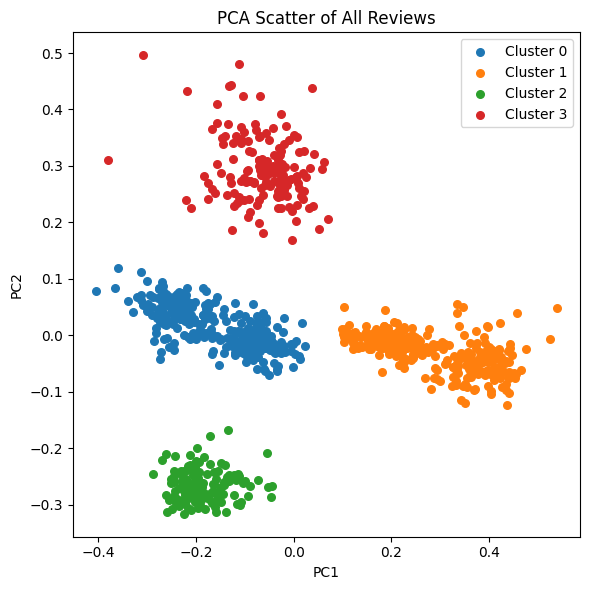

In [9]:
# ÏÖÄ 1) ÎùºÏù¥Î∏åÎü¨Î¶¨ import
import os
import json
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ÏÖÄ 2) ÏòÅÌôî ID ‚Üí Ï†úÎ™© Îß§Ìïë ÏÉùÏÑ±
MOVIE_DIR = "./movie_data"
movie_title_map = {}
for fn in os.listdir(MOVIE_DIR):
    if not fn.endswith("_info.json"):
        continue
    mid = fn.split("_")[0]
    info = json.load(open(f"{MOVIE_DIR}/{fn}", encoding="utf8"))
    movie_title_map[mid] = info["ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥"]["Ï†úÎ™©"]

import os, json, numpy as np

CACHE_DIR = "./attn_cache"
movie_ids = [fn.split("_")[0]
             for fn in os.listdir(CACHE_DIR)
             if fn.endswith("_hmap.npz")]

# Î¶¨Î∑∞ Î≤°ÌÑ∞Î•º Îã¥ÏùÑ Î¶¨Ïä§Ìä∏
all_rev_vecs = []
all_rev_labels = []  # (mid, rev_idx) Ï†ïÎ≥¥

for mid in movie_ids:
    # 1) Ìï¥Îãπ ÏòÅÌôîÏùò hmap Î∂àÎü¨Ïò§Í∏∞
    data = np.load(f"{CACHE_DIR}/{mid}_hmap.npz", allow_pickle=True)
    mats = data["mats"]  # object Î∞∞Ïó¥, Í∞Å Î¶¨Î∑∞Ïùò word_mat
    # 2) Î¶¨Î∑∞Î≥ÑÎ°ú word_mat.sum(axis=0) ‚Üí Î≤°ÌÑ∞
    for i, mat in enumerate(mats):
        rev_vec = mat.sum(axis=0)              # (src_len,) Î≤°ÌÑ∞
        all_rev_vecs.append(rev_vec)
        all_rev_labels.append((mid, i))

# 3) Í∏∏Ïù¥ ÎßûÏ∂∞ Ìå®Îî©
lengths = [v.shape[0] for v in all_rev_vecs]
max_len = max(lengths)
X = np.zeros((len(all_rev_vecs), max_len))
for i, v in enumerate(all_rev_vecs):
    L = v.shape[0]
    X[i, :L] = v if L <= max_len else v[:max_len]

print("Total review vectors:", X.shape)  # (n_reviews, n_features)

# ÏÖÄ 4) Ï†ïÍ∑úÌôî & Ïú†ÏÇ¨ÎèÑ ÌñâÎ†¨
X_norm = normalize(X, norm="l2")
sim_mat = cosine_similarity(X_norm)

# ÏÖÄ 5) K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_norm)
labels = kmeans.labels_

# # ÏÖÄ 6) Îç¥ÎìúÎ°úÍ∑∏Îû® (xÏ∂ï: ÏòÅÌôî Ï†úÎ™©Îßå)
# plt.figure(figsize=(12, 4))
# # ÏòàÏãú A) ÏòÅÌôî Ï†úÎ™©Îßå ÎùºÎ≤®Î°ú
# dend_labels = [ movie_title_map.get(mid, mid)
#                  for mid, rev_idx in all_rev_labels ]

# ÏòàÏãú B) ÏòÅÌôî Ï†úÎ™© + Î¶¨Î∑∞ Î≤àÌò∏ÍπåÏßÄ
# dend_labels = [ f"{movie_title_map.get(mid,mid)}_r{rev_idx}"
#                  for mid, rev_idx in all_rev_labels ]

# linkage Îäî Î¶¨Î∑∞Î≥ÑÎ°ú ÏåìÏù∏ X_norm ÏúºÎ°ú Í≥ÑÏÇ∞ÌñàÏúºÎØÄÎ°ú
Z = linkage(X_norm, method="ward")


# ÏÖÄ 7) PCA 2D ÏãúÍ∞ÅÌôî (Î™®Îì† Î¶¨Î∑∞ Ìè¨Ïù∏Ìä∏)
X_pca = PCA(n_components=2).fit_transform(X_norm)
plt.figure(figsize=(6, 6))
for lbl in range(n_clusters):
    idxs = np.where(labels == lbl)[0]
    plt.scatter(
        X_pca[idxs, 0],
        X_pca[idxs, 1],
        s=30,
        label=f"Cluster {lbl}"
    )
plt.legend()
plt.title("PCA Scatter of All Reviews")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [10]:
# ÏÖÄ 8) PlotlyÎ°ú ÎåÄÌôîÌòï PCA Ïä§Ï∫êÌÑ∞ + Ìò∏Î≤Ñ Ìà¥ÌåÅ
import pandas as pd
import plotly.express as px
import json

# 1) all_rev_labels Í∏∞Î∞òÏúºÎ°ú ÏõêÎ≥∏ Î¶¨Î∑∞ ÌÖçÏä§Ìä∏ Î°úÎìú
all_rev_texts = []
for mid, rev_idx in all_rev_labels:
    path = f"{MOVIE_DIR}/{mid}_reviews.json"
    revs = json.load(open(path, encoding="utf8"))["reviews"]
    all_rev_texts.append(revs[rev_idx])

# 2) Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Cluster": labels.astype(str),
    "Review": all_rev_texts
})

# 3) Ïù∏ÌÑ∞ÎûôÌã∞Î∏å Ïä§Ï∫êÌÑ∞ Í∑∏Î¶¨Í∏∞
fig = px.scatter(
    df,
    x="PC1",
    y="PC2",
    color="Cluster",
    hover_data=["Review"],
    title="Interactive PCA Scatter of Reviews"
)
fig.update_traces(marker=dict(size=8))
#fig.show()

fig.write_html("interactive_pca.html", include_plotlyjs="cdn")

# ÎåÄÏãúÎ≥¥Îìú ÌïòÎÇòÎ°ú Ìï©ÏπòÍ∏∞

In [208]:
# enhanced_dashboard.py
import os
import json
import numpy as np
import pandas as pd
from jinja2 import Template
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
CACHE_DIR = "./attn_cache"
MOVIE_DIR = "./movie_data"
OUT_HTML = "enhanced_dashboard.html"

# --- 1. ÏòÅÌôî Î©îÌÉÄ Ï†ïÎ≥¥ Î°úÎìú ---
movies = []
movie_ids = sorted([f.split("_")[0] for f in os.listdir(CACHE_DIR) if f.endswith("_vec.npy")])
movie_title_map = {}

for mid in movie_ids:
    # ÏòÅÌôî Ï†ïÎ≥¥ Î°úÎìú
    info = json.load(open(f"{MOVIE_DIR}/{mid}_info.json", encoding="utf8"))
    title = info["ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥"]["Ï†úÎ™©"]
    movie_title_map[mid] = title
    
    # ÏßëÍ≥Ñ Î≤°ÌÑ∞ + ÌÜ†ÌÅ∞
    vec = np.sqrt(np.load(f"{CACHE_DIR}/{mid}_vec.npy")).tolist()
    toks = json.load(open(f"{CACHE_DIR}/{mid}_tok.json", encoding="utf8"))["tokens"]
    
    # ÌûàÌä∏Îßµ
    h = np.load(f"{CACHE_DIR}/{mid}_hmap.npz", allow_pickle=True)
    mats = [m.tolist() for m in h["mats"]]
    ys = [list(y) for y in h["ys"]]
    
    movies.append(dict(id=mid, title=title, vec=vec, toks=toks, mats=mats, ys=ys))

print(f"Ï¥ù {len(movies)}Í∞ú ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")

# --- 2. ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏùÑ ÏúÑÌïú Î¶¨Î∑∞ Î≤°ÌÑ∞ Íµ¨ÏÑ± ---
all_rev_vecs = []
all_rev_info = []  # Í∞Å Î¶¨Î∑∞Ïóê ÎåÄÌïú Ï†ïÎ≥¥: {movie_id, movie_title, review_idx, review_text}

for movie in movies:
    mid = movie["id"]
    title = movie["title"]
    
    # Î¶¨Î∑∞ ÌÖçÏä§Ìä∏ Î°úÎìú
    try:
        reviews = json.load(open(f"{MOVIE_DIR}/{mid}_reviews.json", encoding="utf8"))["reviews"]
    except:
        print(f"Î¶¨Î∑∞ ÌååÏùº ÏóÜÏùå: {mid}")
        reviews = [""] * len(movie["mats"])
    
    # Í∞Å Î¶¨Î∑∞Ïóê ÎåÄÌïú Î≤°ÌÑ∞ ÏÉùÏÑ±
    for i, mat in enumerate(movie["mats"]):
        if i >= len(reviews):  # Î¶¨Î∑∞ ÏàòÏôÄ ÌñâÎ†¨ ÏàòÍ∞Ä ÎßûÏßÄ ÏïäÎäî Í≤ΩÏö∞ Ï≤òÎ¶¨
            review_text = f"Î¶¨Î∑∞ {i}"
        else:
            review_text = reviews[i][:100] + "..." if len(reviews[i]) > 100 else reviews[i]
        
        # Î¶¨Î∑∞ Î≤°ÌÑ∞ (Îã®Ïñ¥ Ïñ¥ÌÖêÏÖòÏùò Ìï©)
        rev_vec = np.array(mat).sum(axis=0)
        all_rev_vecs.append(rev_vec)
        
        # Î¶¨Î∑∞ Ï†ïÎ≥¥ Ï†ÄÏû•
        all_rev_info.append({
            "movie_id": mid,
            "movie_idx": movie_ids.index(mid),  # ÏòÅÌôî Ïù∏Îç±Ïä§
            "movie_title": title,
            "review_idx": i,
            "review_text": review_text
        })

# --- 3. Î¶¨Î∑∞ Î≤°ÌÑ∞ Ï†ïÍ∑úÌôî Î∞è PCA Ï†ÅÏö© ---
# Í∏∏Ïù¥ ÎßûÏ∂∞ Ìå®Îî©
lengths = [v.shape[0] for v in all_rev_vecs]
max_len = max(lengths)
X = np.zeros((len(all_rev_vecs), max_len))
for i, v in enumerate(all_rev_vecs):
    L = v.shape[0]
    X[i, :L] = v if L <= max_len else v[:max_len]

# Ï†ïÍ∑úÌôî Î∞è PCA
X_norm = normalize(X, norm="l2")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_norm)
labels = kmeans.labels_

# --- 4. ÌÅ¥Îü¨Ïä§ÌÑ∞ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ---
cluster_data = []
for i, info in enumerate(all_rev_info):
    cluster_data.append({
        "x": float(X_pca[i, 0]),
        "y": float(X_pca[i, 1]),
        "cluster": int(labels[i]),
        "movie_id": info["movie_id"],
        "movie_idx": info["movie_idx"],
        "movie_title": info["movie_title"],
        "review_idx": info["review_idx"],
        "review_text": info["review_text"]
    })

# --- 5. Jinja HTML ÌÖúÌîåÎ¶ø ---
tpl = Template("""
<!DOCTYPE html>
<html lang="ko">
<head>
  <meta charset="utf-8">
  <title>Ìñ•ÏÉÅÎêú ÏòÅÌôî Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú</title>
  <script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>
  <style>
    /* Í∏∞Î≥∏ Ïä§ÌÉÄÏùº Î≥ÄÏàò Ï†ïÏùò */
    :root {
      --primary-color: #4a6eb5;
      --secondary-color: #6c8ecc;
      --accent-color: #ffd166;
      --text-color: #333;
      --background-color: #f9f9f9;
      --card-background: #ffffff;
      --spacing-sm: 8px;
      --spacing-md: 16px;
      --spacing-lg: 30px;
      --border-radius: 8px;
      --shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
      --transition-time: 0.3s;
    }

    /* Í∏ÄÎ°úÎ≤å Ïä§ÌÉÄÏùº */
    body {
      font-family: 'Noto Sans KR', sans-serif;
      margin: 0;
      padding: var(--spacing-lg);
      background-color: var(--background-color);
      color: var(--text-color);
      line-height: 1.6;
    }

    /* Î†àÏù¥ÏïÑÏõÉ Ïª¥Ìè¨ÎÑåÌä∏ */
    .container {
      max-width: 1400px;
      margin: 0 auto;
    }

    .header {
      display: flex;
      justify-content: space-between;
      align-items: center;
      margin-bottom: var(--spacing-lg);
      padding-bottom: var(--spacing-md);
      border-bottom: 1px solid #e0e0e0;
    }

    .title {
      font-size: 24px;
      font-weight: 700;
      color: var(--primary-color);
      margin: 0;
    }

    .control-panel {
      display: flex;
      align-items: center;
      gap: var(--spacing-lg);
      background-color: var(--card-background);
      padding: var(--spacing-md);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      margin-bottom: var(--spacing-lg);
    }

    .control-group {
      display: flex;
      align-items: center;
      gap: var(--spacing-sm);
    }

    .control-label {
      font-weight: 500;
      min-width: 80px;
    }

    /* ÏûÖÎ†• Ïª¥Ìè¨ÎÑåÌä∏ Ïä§ÌÉÄÏùº */
    select, input[type="range"] {
      padding: 8px 12px;
      font-size: 15px;
      border: 1px solid #ccc;
      border-radius: var(--border-radius);
      background-color: white;
      transition: all var(--transition-time);
    }

    select {
      min-width: 200px;
      cursor: pointer;
    }

    select:hover, input[type="range"]:hover {
      border-color: var(--primary-color);
    }

    /* ÎåÄÏãúÎ≥¥Îìú Í∑∏Î¶¨Îìú */
    .visualization-grid {
      display: grid;
      grid-template-columns: 1fr 1fr;
      gap: var(--spacing-lg);
      margin-bottom: var(--spacing-lg);
    }

    .full-width {
      grid-column: 1 / -1;
    }

    .chart-container {
      background-color: var(--card-background);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      overflow: hidden;
      padding: var(--spacing-md);
      height: 450px;
    }

    .chart-title {
      font-size: 18px;
      font-weight: 500;
      margin-top: 0;
      margin-bottom: var(--spacing-md);
      color: var(--primary-color);
    }

    /* Î¶¨Î∑∞ Ïπ¥Ïö¥ÌÑ∞ Ïä§ÌÉÄÏùº */
    .review-counter {
      display: inline-block;
      background-color: var(--accent-color);
      color: var(--text-color);
      padding: 4px 10px;
      border-radius: var(--border-radius);
      font-weight: 500;
      min-width: 30px;
      text-align: center;
    }

    /* Î¶¨Î∑∞ Ï†ïÎ≥¥ Ìå®ÎÑê */
    .review-info {
      background-color: var(--card-background);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      padding: var(--spacing-md);
      margin-bottom: var(--spacing-lg);
      max-height: 100px;
      overflow-y: auto;
    }

    .review-text {
      font-style: italic;
      color: #555;
    }
  </style>
</head>
<body>
  <div class="container">
    <header class="header">
      <h1 class="title">üé¨ Ìñ•ÏÉÅÎêú ÏòÅÌôî Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú</h1>
    </header>

    <div class="control-panel">
      <div class="control-group">
        <label class="control-label" for="movieSelect">ÏòÅÌôî ÏÑ†ÌÉù:</label>
        <select id="movieSelect" aria-label="ÏòÅÌôî ÏÑ†ÌÉù"></select>
      </div>
      
      <div class="control-group">
        <label class="control-label" for="reviewSlider">Î¶¨Î∑∞:</label>
        <input type="range" id="reviewSlider" min="0" max="0" value="0" aria-label="Î¶¨Î∑∞ ÏÑ†ÌÉù">
        <span id="reviewIndex" class="review-counter">0</span>
      </div>
    </div>

    <div class="review-info" id="reviewInfo">
      <p>Î¶¨Î∑∞Î•º Ìò∏Î≤ÑÌïòÍ±∞ÎÇò Ïä¨ÎùºÏù¥ÎçîÎ°ú ÏÑ†ÌÉùÌïòÏÑ∏Ïöî.</p>
    </div>

    <!-- ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï∞®Ìä∏ (Ï†ÑÏ≤¥ ÎÑàÎπÑ) -->
    <div class="visualization-grid">
      <div class="chart-container full-width">
        <h2 class="chart-title">Î¶¨Î∑∞ ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÏÑù</h2>
        <div id="clusterChart"></div>
      </div>
    </div>

    <!-- Í∏∞Ï°¥ Ï∞®Ìä∏ -->
    <div class="visualization-grid">
      <div class="chart-container">
        <h2 class="chart-title">ÏßëÍ≥ÑÎêú Ïñ¥ÌÖêÏÖò Ï†êÏàò</h2>
        <div id="barChart"></div>
      </div>
      <div class="chart-container">
        <h2 class="chart-title">Î¶¨Î∑∞-ÏòÅÌôî Ï†ïÎ≥¥ Ïñ¥ÌÖêÏÖò ÌûàÌä∏Îßµ</h2>
        <div id="heatmapChart"></div>
      </div>
    </div>
  </div>

  <script>
    // ÏÉÅÏàò Ï†ïÏùò
    const DOM_IDS = {
      movieSelect: 'movieSelect',
      reviewSlider: 'reviewSlider',
      reviewIndex: 'reviewIndex',
      reviewInfo: 'reviewInfo',
      clusterChart: 'clusterChart',
      barChart: 'barChart',
      heatmapChart: 'heatmapChart'
    };

    // Ï∞®Ìä∏ ÏÑ§Ï†ï
    const ChartConfig = {
      bar: {
        margin: {l: 50, r: 30, t: 50, b: 100},
        xaxisTickAngle: 45,
        getTitleText: (title) => `${title} ‚Äì Ïπ¥ÌÖåÍ≥†Î¶¨ ÏßëÍ≥Ñ (min‚Äìmax)`
      },
      heatmap: {
        margin: {l: 70, r: 30, t: 50, b: 50},
        colorscale: 'Viridis',
        getTitleText: (index) => `Î¶¨Î∑∞ ${index} √ó Ïπ¥ÌÖåÍ≥†Î¶¨`
      },
      cluster: {
        margin: {l: 50, r: 30, t: 50, b: 50},
        colorScale: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
      }
    };

    // DOM ÏöîÏÜå
    const elements = {
      movieSelect: document.getElementById(DOM_IDS.movieSelect),
      reviewSlider: document.getElementById(DOM_IDS.reviewSlider),
      reviewIndex: document.getElementById(DOM_IDS.reviewIndex),
      reviewInfo: document.getElementById(DOM_IDS.reviewInfo),
      clusterChart: document.getElementById(DOM_IDS.clusterChart),
      barChart: document.getElementById(DOM_IDS.barChart),
      heatmapChart: document.getElementById(DOM_IDS.heatmapChart)
    };

    // ÌÜµÌï© ÎåÄÏãúÎ≥¥Îìú Í∞ùÏ≤¥
    const MovieDashboard = {
      data: {{ movies | tojson }},
      clusterData: {{ cluster_data | tojson }},
      currentMovieIndex: 0,
      currentReviewIndex: 0,
      selectedPoint: null,
      
      // Ï¥àÍ∏∞Ìôî
      initialize() {
        this.populateMovieSelect();
        this.setupEventListeners();
        this.updateReviewSlider();
        this.renderClusterChart();
        this.renderCharts();
      },
      
      // ÏòÅÌôî ÏÑ†ÌÉù Î∞ïÏä§ Ï±ÑÏö∞Í∏∞
      populateMovieSelect() {
        this.data.forEach((movie, index) => {
          elements.movieSelect.add(new Option(movie.title, index));
        });
      },
      
      // Ïù¥Î≤§Ìä∏ Î¶¨Ïä§ÎÑà ÏÑ§Ï†ï
      setupEventListeners() {
        elements.movieSelect.addEventListener('change', () => {
          this.currentMovieIndex = parseInt(elements.movieSelect.value);
          this.currentReviewIndex = 0;
          this.updateReviewSlider();
          this.renderCharts();
          this.highlightClusterPoints();
        });
        
        elements.reviewSlider.addEventListener('input', () => {
          this.currentReviewIndex = parseInt(elements.reviewSlider.value);
          elements.reviewIndex.textContent = this.currentReviewIndex;
          this.updateReviewInfo();
          this.renderHeatmap();
          this.highlightClusterPoints();
        });
      },
      
      // Î¶¨Î∑∞ Ïä¨ÎùºÏù¥Îçî ÏóÖÎç∞Ïù¥Ìä∏
      updateReviewSlider() {
        const currentMovie = this.data[this.currentMovieIndex];
        const reviewCount = currentMovie.mats.length;
        
        elements.reviewSlider.min = 0;
        elements.reviewSlider.max = reviewCount - 1;
        elements.reviewSlider.value = this.currentReviewIndex;
        elements.reviewIndex.textContent = this.currentReviewIndex;
        this.updateReviewInfo();
      },
      
      // Î¶¨Î∑∞ Ï†ïÎ≥¥ ÏóÖÎç∞Ïù¥Ìä∏
      updateReviewInfo(review) {
        // ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú ÏßÅÏ†ë ÏÑ†ÌÉùÌïú Î¶¨Î∑∞ Ï†ïÎ≥¥Í∞Ä ÏûàÎäî Í≤ΩÏö∞
        if (review) {
          elements.reviewInfo.innerHTML = `
            <strong>${review.movie_title}</strong>Ïùò Î¶¨Î∑∞ ${review.review_idx}:<br>
            <span class="review-text">"${review.review_text}"</span>
          `;
          return;
        }
        
        // Ïä¨ÎùºÏù¥ÎçîÎ°ú ÏÑ†ÌÉùÌïú Î¶¨Î∑∞ Ï†ïÎ≥¥ ÌëúÏãú
        const movieId = this.data[this.currentMovieIndex].id;
        const matchingReviews = this.clusterData.filter(
          r => r.movie_id === movieId && r.review_idx === this.currentReviewIndex
        );
        
        if (matchingReviews.length > 0) {
          const rev = matchingReviews[0];
          elements.reviewInfo.innerHTML = `
            <strong>${rev.movie_title}</strong>Ïùò Î¶¨Î∑∞ ${rev.review_idx} (ÌÅ¥Îü¨Ïä§ÌÑ∞ ${rev.cluster}):<br>
            <span class="review-text">"${rev.review_text}"</span>
          `;
        } else {
          elements.reviewInfo.innerHTML = `<p>Î¶¨Î∑∞ ${this.currentReviewIndex} Ï†ïÎ≥¥Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.</p>`;
        }
      },
      
      // Ï∞®Ìä∏ Î†åÎçîÎßÅ (ÎßâÎåÄ + ÌûàÌä∏Îßµ)
      renderCharts() {
        this.renderBarChart();
        this.renderHeatmap();
      },
      
      // ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï∞®Ìä∏ Î†åÎçîÎßÅ
      renderClusterChart() {
        // ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
        const clusterIds = [...new Set(this.clusterData.map(d => d.cluster))].sort();
        const traces = clusterIds.map(clusterId => {
          const points = this.clusterData.filter(d => d.cluster === clusterId);
          return {
            x: points.map(p => p.x),
            y: points.map(p => p.y),
            mode: 'markers',
            type: 'scatter',
            name: `ÌÅ¥Îü¨Ïä§ÌÑ∞ ${clusterId}`,
            text: points.map(p => `${p.movie_title} - Î¶¨Î∑∞ ${p.review_idx}`),
            hovertemplate: '%{text}<br>%{customdata}<extra></extra>',
            customdata: points.map(p => p.review_text),
            marker: {
              size: 10,
              opacity: 0.7
            },
            reviewData: points // Í∞Å Ï†êÏóê Ìï¥ÎãπÌïòÎäî Î¶¨Î∑∞ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
          };
        });

        const layout = {
          title: 'Î¶¨Î∑∞ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ (PCA)',
          xaxis: { title: 'PC1' },
          yaxis: { title: 'PC2' },
          margin: ChartConfig.cluster.margin,
          hovermode: 'closest',
          legend: { orientation: 'h', y: -0.2 }
        };

        Plotly.newPlot(DOM_IDS.clusterChart, traces, layout);

        // Ìò∏Î≤Ñ Ïù¥Î≤§Ìä∏ Î¶¨Ïä§ÎÑà Ï∂îÍ∞Ä
        const clusterElement = document.getElementById(DOM_IDS.clusterChart);
        clusterElement.on('plotly_hover', (data) => {
          const point = data.points[0];
          const traceIndex = point.curveNumber;
          const pointIndex = point.pointIndex;
          const reviewData = traces[traceIndex].reviewData[pointIndex];
          
          // ÌòÑÏû¨ ÏÑ†ÌÉùÎêú ÏòÅÌôîÏôÄ Î¶¨Î∑∞ Ïù∏Îç±Ïä§ ÏóÖÎç∞Ïù¥Ìä∏
          if (reviewData) {
            this.selectedPoint = reviewData;
            this.updateReviewInfo(reviewData);
            
            // Í∞ôÏùÄ ÏòÅÌôîÏùò Îã§Î•∏ Î¶¨Î∑∞Î•º Î≥¥Í≥† ÏûàÏóàÎã§Î©¥, Ìï¥Îãπ ÏòÅÌôî Ïú†ÏßÄÌïòÍ≥† Î¶¨Î∑∞Îßå Î≥ÄÍ≤Ω
            if (this.currentMovieIndex === reviewData.movie_idx) {
              this.currentReviewIndex = reviewData.review_idx;
              elements.reviewSlider.value = this.currentReviewIndex;
              elements.reviewIndex.textContent = this.currentReviewIndex;
              this.renderHeatmap();
            } else {
              // Îã§Î•∏ ÏòÅÌôîÏùò Î¶¨Î∑∞ÎùºÎ©¥ ÏòÅÌôîÏôÄ Î¶¨Î∑∞ Î™®Îëê Î≥ÄÍ≤Ω
              this.currentMovieIndex = reviewData.movie_idx;
              this.currentReviewIndex = reviewData.review_idx;
              elements.movieSelect.value = this.currentMovieIndex;
              this.updateReviewSlider();
              this.renderCharts();
            }
          }
        });
      },
      
      // ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï∞®Ìä∏ÏóêÏÑú ÌòÑÏû¨ ÏÑ†ÌÉùÎêú Î¶¨Î∑∞ Í∞ïÏ°∞ ÌëúÏãú
      highlightClusterPoints() {
        const clusterElement = document.getElementById(DOM_IDS.clusterChart);
        if (!clusterElement || !clusterElement.data) return;
        
        const currentMovieId = this.data[this.currentMovieIndex].id;
        
        // Î™®Îì† Ìè¨Ïù∏Ìä∏Ïùò ÌÅ¨Í∏∞ÏôÄ Ìà¨Î™ÖÎèÑ Ï¥àÍ∏∞Ìôî
        const update = {
          'marker.size': [],
          'marker.opacity': [],
          'marker.color': []
        };
        
        for (let i = 0; i < clusterElement.data.length; i++) {
          const trace = clusterElement.data[i];
          const sizes = [];
          const opacities = [];
          const colors = [];
          const defaultColor = ChartConfig.cluster.colorScale[i % ChartConfig.cluster.colorScale.length];
          
          for (let j = 0; j < trace.reviewData.length; j++) {
            const reviewData = trace.reviewData[j];
            const isCurrentMovie = reviewData.movie_id === currentMovieId;
            const isCurrentReview = isCurrentMovie && reviewData.review_idx === this.currentReviewIndex;
            
            sizes.push(isCurrentReview ? 16 : isCurrentMovie ? 12 : 10);
            opacities.push(isCurrentReview ? 1.0 : isCurrentMovie ? 0.8 : 0.5);
            colors.push(isCurrentReview ? '#FF5733' : defaultColor);
          }
          
          update['marker.size'].push(sizes);
          update['marker.opacity'].push(opacities);
          update['marker.color'].push(colors);
        }
        
        Plotly.update(DOM_IDS.clusterChart, update);
      },
      
      // ÎßâÎåÄ Í∑∏ÎûòÌîÑ Î†åÎçîÎßÅ
      renderBarChart() {
        const currentMovie = this.data[this.currentMovieIndex];
        
        // Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî Ìï®Ïàò
        const normalizeData = (data) => {
          const total = data.reduce((sum, value) => sum + value, 0) || 1;
          const normalized = data.map(value => value / total);
          const min = Math.min(...normalized);
          const max = Math.max(...normalized);
          const range = max - min || 1;
          
          return normalized.map(value => (value - min) / range);
        };
        
        // ÌÜ†ÌÅ∞ ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò
        const cleanTokens = (tokens) => tokens.map(token => token.replace(/^‚ñÅ/, ""));
        
        // Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞ÏôÄ Ï†ïÏ†úÎêú ÌÜ†ÌÅ∞ÏúºÎ°ú Ï∞®Ìä∏ ÏÉùÏÑ±
        const scaledData = normalizeData(currentMovie.vec);
        
        Plotly.newPlot(DOM_IDS.barChart, [{
          x: cleanTokens(currentMovie.toks),
          y: scaledData,
          type: 'bar',
          marker: {
            color: scaledData,
            colorscale: 'Blues'
          }
        }], {
          title: ChartConfig.bar.getTitleText(currentMovie.title),
          margin: ChartConfig.bar.margin,
          xaxis: {
            tickangle: ChartConfig.bar.xaxisTickAngle
          }
        });
      },
      
      // ÌûàÌä∏Îßµ Î†åÎçîÎßÅ
      renderHeatmap() {
        const currentMovie = this.data[this.currentMovieIndex];
        const reviewMatrix = currentMovie.mats[this.currentReviewIndex];
        
        // ÌÜ†ÌÅ∞ ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò - Ïû¨ÏÇ¨Ïö©
        const cleanTokens = (tokens) => tokens.map(token => token.replace(/^‚ñÅ/, ""));
        
        Plotly.newPlot(DOM_IDS.heatmapChart, [{
          z: reviewMatrix,
          x: cleanTokens(currentMovie.toks),
          y: cleanTokens(currentMovie.ys[this.currentReviewIndex]),
          type: 'heatmap',
          colorscale: ChartConfig.heatmap.colorscale
        }], {
          title: ChartConfig.heatmap.getTitleText(this.currentReviewIndex),
          margin: ChartConfig.heatmap.margin,
          yaxis: { 
            autorange: 'reversed' 
          }
        });
      }
    };
    
    // ÌéòÏù¥ÏßÄ Î°úÎìú Ïãú ÎåÄÏãúÎ≥¥Îìú Ï¥àÍ∏∞Ìôî
    document.addEventListener('DOMContentLoaded', () => {
      MovieDashboard.initialize();
    });
  </script>
</body>
</html>
""")

# ÌÖúÌîåÎ¶øÏóê Îç∞Ïù¥ÌÑ∞ Ï†ÑÎã¨ÌïòÏó¨ HTML ÏÉùÏÑ±
with open(OUT_HTML, "w", encoding="utf8") as f:
    f.write(tpl.render(movies=movies, cluster_data=cluster_data))

print(f"‚úÖ {OUT_HTML} ÏÉùÏÑ± ÏôÑÎ£å ‚Äì Î∏åÎùºÏö∞Ï†ÄÏóêÏÑú Ïó¥Ïñ¥ÏÑú ÌôïÏù∏ÌïòÏÑ∏Ïöî")

Ï¥ù 6Í∞ú ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å
‚úÖ enhanced_dashboard.html ÏÉùÏÑ± ÏôÑÎ£å ‚Äì Î∏åÎùºÏö∞Ï†ÄÏóêÏÑú Ïó¥Ïñ¥ÏÑú ÌôïÏù∏ÌïòÏÑ∏Ïöî


# ÏµúÏ¢Ö ÎåÄÏãúÎ≥¥Îìú Î≤ÑÏ†Ñ

In [11]:
# enhanced_dashboard.py
import os
import json
import numpy as np
import pandas as pd
from jinja2 import Template
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
CACHE_DIR = "./attn_cache"
MOVIE_DIR = "./movie_data"
OUT_HTML = "enhanced_dashboard.html"

# --- 1. ÏòÅÌôî Î©îÌÉÄ Ï†ïÎ≥¥ Î°úÎìú ---
movies = []
movie_ids = sorted([f.split("_")[0] for f in os.listdir(CACHE_DIR) if f.endswith("_vec.npy")])
movie_title_map = {}

for mid in movie_ids:
    # ÏòÅÌôî Ï†ïÎ≥¥ Î°úÎìú
    info = json.load(open(f"{MOVIE_DIR}/{mid}_info.json", encoding="utf8"))
    title = info["ÏòÅÌôî Í∏∞Î≥∏ Ï†ïÎ≥¥"]["Ï†úÎ™©"]
    movie_title_map[mid] = title
    
    # ÏßëÍ≥Ñ Î≤°ÌÑ∞ + ÌÜ†ÌÅ∞
    vec = np.sqrt(np.load(f"{CACHE_DIR}/{mid}_vec.npy")).tolist()
    toks = json.load(open(f"{CACHE_DIR}/{mid}_tok.json", encoding="utf8"))["tokens"]
    
    # ÌûàÌä∏Îßµ
    h = np.load(f"{CACHE_DIR}/{mid}_hmap.npz", allow_pickle=True)
    mats = [m.tolist() for m in h["mats"]]
    ys = [list(y) for y in h["ys"]]
    
    movies.append(dict(id=mid, title=title, vec=vec, toks=toks, mats=mats, ys=ys))

print(f"Ï¥ù {len(movies)}Í∞ú ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")

# --- 2. ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏùÑ ÏúÑÌïú Î¶¨Î∑∞ Î≤°ÌÑ∞ Íµ¨ÏÑ± ---
all_rev_vecs = []
all_rev_info = []  # Í∞Å Î¶¨Î∑∞Ïóê ÎåÄÌïú Ï†ïÎ≥¥: {movie_id, movie_title, review_idx, review_text}

for movie in movies:
    mid = movie["id"]
    title = movie["title"]
    
    # Î¶¨Î∑∞ ÌÖçÏä§Ìä∏ Î°úÎìú
    try:
        reviews = json.load(open(f"{MOVIE_DIR}/{mid}_reviews.json", encoding="utf8"))["reviews"]
    except:
        print(f"Î¶¨Î∑∞ ÌååÏùº ÏóÜÏùå: {mid}")
        reviews = [""] * len(movie["mats"])
    
    # Í∞Å Î¶¨Î∑∞Ïóê ÎåÄÌïú Î≤°ÌÑ∞ ÏÉùÏÑ±
    for i, mat in enumerate(movie["mats"]):
        if i >= len(reviews):  # Î¶¨Î∑∞ ÏàòÏôÄ ÌñâÎ†¨ ÏàòÍ∞Ä ÎßûÏßÄ ÏïäÎäî Í≤ΩÏö∞ Ï≤òÎ¶¨
            review_text = f"Î¶¨Î∑∞ {i}"
        else:
            review_text = reviews[i][:100] + "..." if len(reviews[i]) > 100 else reviews[i]
        
        # Î¶¨Î∑∞ Î≤°ÌÑ∞ (Îã®Ïñ¥ Ïñ¥ÌÖêÏÖòÏùò Ìï©)
        rev_vec = np.array(mat).sum(axis=0)
        all_rev_vecs.append(rev_vec)
        
        # Î¶¨Î∑∞ Ï†ïÎ≥¥ Ï†ÄÏû•
        all_rev_info.append({
            "movie_id": mid,
            "movie_idx": movie_ids.index(mid),  # ÏòÅÌôî Ïù∏Îç±Ïä§
            "movie_title": title,
            "review_idx": i,
            "review_text": review_text
        })

# --- 3. Î¶¨Î∑∞ Î≤°ÌÑ∞ Ï†ïÍ∑úÌôî Î∞è PCA Ï†ÅÏö© ---
# Í∏∏Ïù¥ ÎßûÏ∂∞ Ìå®Îî©
lengths = [v.shape[0] for v in all_rev_vecs]
max_len = max(lengths)
X = np.zeros((len(all_rev_vecs), max_len))
for i, v in enumerate(all_rev_vecs):
    L = v.shape[0]
    X[i, :L] = v if L <= max_len else v[:max_len]

# Ï†ïÍ∑úÌôî Î∞è PCA
X_norm = normalize(X, norm="l2")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_norm)
labels = kmeans.labels_

# --- 4. ÌÅ¥Îü¨Ïä§ÌÑ∞ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ---
cluster_data = []
for i, info in enumerate(all_rev_info):
    cluster_data.append({
        "x": float(X_pca[i, 0]),
        "y": float(X_pca[i, 1]),
        "cluster": int(labels[i]),
        "movie_id": info["movie_id"],
        "movie_idx": info["movie_idx"],
        "movie_title": info["movie_title"],
        "review_idx": info["review_idx"],
        "review_text": info["review_text"]
    })

# --- 5. Jinja HTML ÌÖúÌîåÎ¶ø ---
tpl = Template("""
<!DOCTYPE html>
<html lang="ko">
<head>
  <meta charset="utf-8">
  <title>Ìñ•ÏÉÅÎêú ÏòÅÌôî Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú</title>
  <script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>
  <style>
    /* Í∏∞Î≥∏ Ïä§ÌÉÄÏùº Î≥ÄÏàò Ï†ïÏùò */
    :root {
      --primary-color: #4a6eb5;
      --secondary-color: #6c8ecc;
      --accent-color: #ffd166;
      --text-color: #333;
      --background-color: #f9f9f9;
      --card-background: #ffffff;
      --spacing-sm: 8px;
      --spacing-md: 16px;
      --spacing-lg: 30px;
      --border-radius: 8px;
      --shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
      --transition-time: 0.3s;
    }

    /* Í∏ÄÎ°úÎ≤å Ïä§ÌÉÄÏùº */
    body {
      font-family: 'Noto Sans KR', sans-serif;
      margin: 0;
      padding: var(--spacing-lg);
      background-color: var(--background-color);
      color: var(--text-color);
      line-height: 1.6;
    }

    /* Î†àÏù¥ÏïÑÏõÉ Ïª¥Ìè¨ÎÑåÌä∏ */
    .container {
      max-width: 1500px;
      margin: 0 auto;
    }

    .header {
      display: flex;
      justify-content: space-between;
      align-items: center;
      margin-bottom: var(--spacing-lg);
      padding-bottom: var(--spacing-md);
      border-bottom: 1px solid #e0e0e0;
    }

    .title {
      font-size: 24px;
      font-weight: 700;
      color: var(--primary-color);
      margin: 0;
    }

    .control-panel {
      display: flex;
      align-items: center;
      gap: var(--spacing-lg);
      background-color: var(--card-background);
      padding: var(--spacing-md);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      margin-bottom: var(--spacing-lg);
    }

    .control-group {
      display: flex;
      align-items: center;
      gap: var(--spacing-sm);
    }

    .control-label {
      font-weight: 500;
      min-width: 80px;
    }

    /* ÏûÖÎ†• Ïª¥Ìè¨ÎÑåÌä∏ Ïä§ÌÉÄÏùº */
    select, input[type="range"] {
      padding: 8px 12px;
      font-size: 15px;
      border: 1px solid #ccc;
      border-radius: var(--border-radius);
      background-color: white;
      transition: all var(--transition-time);
    }

    select {
      min-width: 200px;
      cursor: pointer;
    }

    select:hover, input[type="range"]:hover {
      border-color: var(--primary-color);
    }

    /* ÎåÄÏãúÎ≥¥Îìú Í∑∏Î¶¨Îìú */
    .visualization-grid {
      display: grid;
      grid-template-columns: 1fr 1fr;
      gap: var(--spacing-lg);
      margin-bottom: var(--spacing-lg);
    }

    .full-width {
      grid-column: 1 / -1;
    }

    .chart-container {
      background-color: var(--card-background);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      overflow: hidden;
      padding: var(--spacing-md);
      height: 550px;
    }

    .chart-title {
      font-size: 18px;
      font-weight: 500;
      margin-top: 0;
      margin-bottom: var(--spacing-md);
      color: var(--primary-color);
    }

    /* Î¶¨Î∑∞ Ïπ¥Ïö¥ÌÑ∞ Ïä§ÌÉÄÏùº */
    .review-counter {
      display: inline-block;
      background-color: var(--accent-color);
      color: var(--text-color);
      padding: 4px 10px;
      border-radius: var(--border-radius);
      font-weight: 500;
      min-width: 30px;
      text-align: center;
    }

    /* Î¶¨Î∑∞ Ï†ïÎ≥¥ Ìå®ÎÑê */
    .review-info {
      background-color: var(--card-background);
      border-radius: var(--border-radius);
      box-shadow: var(--shadow);
      padding: var(--spacing-md);
      margin-bottom: var(--spacing-lg);
      max-height: 100px;
      overflow-y: auto;
    }

    .review-text {
      font-style: italic;
      color: #555;
    }
  </style>
</head>
<body>
  <div class="container">
    <header class="header">
      <h1 class="title">üé¨ Ìñ•ÏÉÅÎêú ÏòÅÌôî Ïñ¥ÌÖêÏÖò ÎåÄÏãúÎ≥¥Îìú</h1>
    </header>

    <div class="control-panel">
      <div class="control-group">
        <label class="control-label" for="movieSelect">ÏòÅÌôî ÏÑ†ÌÉù:</label>
        <select id="movieSelect" aria-label="ÏòÅÌôî ÏÑ†ÌÉù"></select>
      </div>
      
      <div class="control-group">
        <label class="control-label" for="reviewSlider">Î¶¨Î∑∞:</label>
        <input type="range" id="reviewSlider" min="0" max="0" value="0" aria-label="Î¶¨Î∑∞ ÏÑ†ÌÉù">
        <span id="reviewIndex" class="review-counter">0</span>
      </div>
    </div>

    <div class="review-info" id="reviewInfo">
      <p>Î¶¨Î∑∞Î•º Ìò∏Î≤ÑÌïòÍ±∞ÎÇò Ïä¨ÎùºÏù¥ÎçîÎ°ú ÏÑ†ÌÉùÌïòÏÑ∏Ïöî.</p>
    </div>

    <!-- ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï∞®Ìä∏ (Ï†ÑÏ≤¥ ÎÑàÎπÑ) -->
    <div class="visualization-grid">
      <div class="chart-container full-width">
        <h2 class="chart-title">Î¶¨Î∑∞ ÌÅ¥Îü¨Ïä§ÌÑ∞ Î∂ÑÏÑù</h2>
        <div id="clusterChart"></div>
      </div>
    </div>

    <!-- Í∏∞Ï°¥ Ï∞®Ìä∏ -->
    <div class="visualization-grid">
      <div class="chart-container">
        <h2 class="chart-title">ÏßëÍ≥ÑÎêú Ïñ¥ÌÖêÏÖò Ï†êÏàò</h2>
        <div id="barChart"></div>
      </div>
      <div class="chart-container">
        <h2 class="chart-title">Î¶¨Î∑∞-ÏòÅÌôî Ï†ïÎ≥¥ Ïñ¥ÌÖêÏÖò ÌûàÌä∏Îßµ</h2>
        <div id="heatmapChart"></div>
      </div>
    </div>
  </div>

  <script>
    // ÏÉÅÏàò Ï†ïÏùò
    const DOM_IDS = {
      movieSelect: 'movieSelect',
      reviewSlider: 'reviewSlider',
      reviewIndex: 'reviewIndex',
      reviewInfo: 'reviewInfo',
      clusterChart: 'clusterChart',
      barChart: 'barChart',
      heatmapChart: 'heatmapChart'
    };

    // Ï∞®Ìä∏ ÏÑ§Ï†ï
    const ChartConfig = {
      bar: {
        margin: {l: 70, r: 50, t: 70, b: 120},
        xaxisTickAngle: 45,
        getTitleText: (title) => `${title} ‚Äì Ïπ¥ÌÖåÍ≥†Î¶¨ ÏßëÍ≥Ñ (min‚Äìmax)`
      },
      heatmap: {
        margin: {l: 100, r: 50, t: 70, b: 70},
        colorscale: 'Viridis',
        getTitleText: (index) => `Î¶¨Î∑∞ ${index} √ó Ïπ¥ÌÖåÍ≥†Î¶¨`
      },
      cluster: {
        margin: {l: 70, r: 50, t: 70, b: 120},
        colorScale: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
      }
    };

    // DOM ÏöîÏÜå
    const elements = {
      movieSelect: document.getElementById(DOM_IDS.movieSelect),
      reviewSlider: document.getElementById(DOM_IDS.reviewSlider),
      reviewIndex: document.getElementById(DOM_IDS.reviewIndex),
      reviewInfo: document.getElementById(DOM_IDS.reviewInfo),
      clusterChart: document.getElementById(DOM_IDS.clusterChart),
      barChart: document.getElementById(DOM_IDS.barChart),
      heatmapChart: document.getElementById(DOM_IDS.heatmapChart)
    };

    // ÌÜµÌï© ÎåÄÏãúÎ≥¥Îìú Í∞ùÏ≤¥
    const MovieDashboard = {
      data: {{ movies | tojson }},
      clusterData: {{ cluster_data | tojson }},
      currentMovieIndex: 0,
      currentReviewIndex: 0,
      selectedPoint: null,
      
      // Ï¥àÍ∏∞Ìôî
      initialize() {
        this.populateMovieSelect();
        this.setupEventListeners();
        this.updateReviewSlider();
        this.renderClusterChart();
        this.renderCharts();
      },
      
      // ÏòÅÌôî ÏÑ†ÌÉù Î∞ïÏä§ Ï±ÑÏö∞Í∏∞
      populateMovieSelect() {
        this.data.forEach((movie, index) => {
          elements.movieSelect.add(new Option(movie.title, index));
        });
      },
      
      // Ïù¥Î≤§Ìä∏ Î¶¨Ïä§ÎÑà ÏÑ§Ï†ï
      setupEventListeners() {
        elements.movieSelect.addEventListener('change', () => {
          this.currentMovieIndex = parseInt(elements.movieSelect.value);
          this.currentReviewIndex = 0;
          this.updateReviewSlider();
          this.renderCharts();
          this.highlightClusterPoints();
        });
        
        elements.reviewSlider.addEventListener('input', () => {
          this.currentReviewIndex = parseInt(elements.reviewSlider.value);
          elements.reviewIndex.textContent = this.currentReviewIndex;
          this.updateReviewInfo();
          this.renderHeatmap();
          this.highlightClusterPoints();
        });
      },
      
      // Î¶¨Î∑∞ Ïä¨ÎùºÏù¥Îçî ÏóÖÎç∞Ïù¥Ìä∏
      updateReviewSlider() {
        const currentMovie = this.data[this.currentMovieIndex];
        const reviewCount = currentMovie.mats.length;
        
        elements.reviewSlider.min = 0;
        elements.reviewSlider.max = reviewCount - 1;
        elements.reviewSlider.value = this.currentReviewIndex;
        elements.reviewIndex.textContent = this.currentReviewIndex;
        this.updateReviewInfo();
      },
      
      // Î¶¨Î∑∞ Ï†ïÎ≥¥ ÏóÖÎç∞Ïù¥Ìä∏
      updateReviewInfo(review) {
        // ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú ÏßÅÏ†ë ÏÑ†ÌÉùÌïú Î¶¨Î∑∞ Ï†ïÎ≥¥Í∞Ä ÏûàÎäî Í≤ΩÏö∞
        if (review) {
          elements.reviewInfo.innerHTML = `
            <strong>${review.movie_title}</strong>Ïùò Î¶¨Î∑∞ ${review.review_idx}:<br>
            <span class="review-text">"${review.review_text}"</span>
          `;
          return;
        }
        
        // Ïä¨ÎùºÏù¥ÎçîÎ°ú ÏÑ†ÌÉùÌïú Î¶¨Î∑∞ Ï†ïÎ≥¥ ÌëúÏãú
        const movieId = this.data[this.currentMovieIndex].id;
        const matchingReviews = this.clusterData.filter(
          r => r.movie_id === movieId && r.review_idx === this.currentReviewIndex
        );
        
        if (matchingReviews.length > 0) {
          const rev = matchingReviews[0];
          elements.reviewInfo.innerHTML = `
            <strong>${rev.movie_title}</strong>Ïùò Î¶¨Î∑∞ ${rev.review_idx} (ÌÅ¥Îü¨Ïä§ÌÑ∞ ${rev.cluster}):<br>
            <span class="review-text">"${rev.review_text}"</span>
          `;
        } else {
          elements.reviewInfo.innerHTML = `<p>Î¶¨Î∑∞ ${this.currentReviewIndex} Ï†ïÎ≥¥Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.</p>`;
        }
      },
      
      // Ï∞®Ìä∏ Î†åÎçîÎßÅ (ÎßâÎåÄ + ÌûàÌä∏Îßµ)
      renderCharts() {
        this.renderBarChart();
        this.renderHeatmap();
      },
      
      // ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï∞®Ìä∏ Î†åÎçîÎßÅ
      renderClusterChart() {
        // ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
        const clusterIds = [...new Set(this.clusterData.map(d => d.cluster))].sort();
        const traces = clusterIds.map(clusterId => {
          const points = this.clusterData.filter(d => d.cluster === clusterId);
          return {
            x: points.map(p => p.x),
            y: points.map(p => p.y),
            mode: 'markers',
            type: 'scatter',
            name: `ÌÅ¥Îü¨Ïä§ÌÑ∞ ${clusterId}`,
            text: points.map(p => `${p.movie_title} - Î¶¨Î∑∞ ${p.review_idx}`),
            hovertemplate: '%{text}<br>%{customdata}<extra></extra>',
            customdata: points.map(p => p.review_text),
            marker: {
              size: 10,
              opacity: 0.7
            },
            reviewData: points // Í∞Å Ï†êÏóê Ìï¥ÎãπÌïòÎäî Î¶¨Î∑∞ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
          };
        });

        const layout = {
          title: 'Î¶¨Î∑∞ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ (PCA)',
          xaxis: { title: 'PC1' },
          yaxis: { title: 'PC2' },
          margin: ChartConfig.cluster.margin,
          hovermode: 'closest',
          legend: { orientation: 'h', y: -0.15 }
        };

        Plotly.newPlot(DOM_IDS.clusterChart, traces, layout);

        // Ìò∏Î≤Ñ Ïù¥Î≤§Ìä∏ Î¶¨Ïä§ÎÑà Ï∂îÍ∞Ä
        const clusterElement = document.getElementById(DOM_IDS.clusterChart);
        clusterElement.on('plotly_hover', (data) => {
          const point = data.points[0];
          const traceIndex = point.curveNumber;
          const pointIndex = point.pointIndex;
          const reviewData = traces[traceIndex].reviewData[pointIndex];
          
          // ÌòÑÏû¨ ÏÑ†ÌÉùÎêú ÏòÅÌôîÏôÄ Î¶¨Î∑∞ Ïù∏Îç±Ïä§ ÏóÖÎç∞Ïù¥Ìä∏
          if (reviewData) {
            this.selectedPoint = reviewData;
            this.updateReviewInfo(reviewData);
            
            // Í∞ôÏùÄ ÏòÅÌôîÏùò Îã§Î•∏ Î¶¨Î∑∞Î•º Î≥¥Í≥† ÏûàÏóàÎã§Î©¥, Ìï¥Îãπ ÏòÅÌôî Ïú†ÏßÄÌïòÍ≥† Î¶¨Î∑∞Îßå Î≥ÄÍ≤Ω
            if (this.currentMovieIndex === reviewData.movie_idx) {
              this.currentReviewIndex = reviewData.review_idx;
              elements.reviewSlider.value = this.currentReviewIndex;
              elements.reviewIndex.textContent = this.currentReviewIndex;
              this.renderHeatmap();
            } else {
              // Îã§Î•∏ ÏòÅÌôîÏùò Î¶¨Î∑∞ÎùºÎ©¥ ÏòÅÌôîÏôÄ Î¶¨Î∑∞ Î™®Îëê Î≥ÄÍ≤Ω
              this.currentMovieIndex = reviewData.movie_idx;
              this.currentReviewIndex = reviewData.review_idx;
              elements.movieSelect.value = this.currentMovieIndex;
              this.updateReviewSlider();
              this.renderCharts();
            }
          }
        });
      },
      
      // ÌÅ¥Îü¨Ïä§ÌÑ∞ Ï∞®Ìä∏ÏóêÏÑú ÌòÑÏû¨ ÏÑ†ÌÉùÎêú Î¶¨Î∑∞ Í∞ïÏ°∞ ÌëúÏãú
      highlightClusterPoints() {
        const clusterElement = document.getElementById(DOM_IDS.clusterChart);
        if (!clusterElement || !clusterElement.data) return;
        
        const currentMovieId = this.data[this.currentMovieIndex].id;
        
        // Î™®Îì† Ìè¨Ïù∏Ìä∏Ïùò ÌÅ¨Í∏∞ÏôÄ Ìà¨Î™ÖÎèÑ Ï¥àÍ∏∞Ìôî
        const update = {
          'marker.size': [],
          'marker.opacity': [],
          'marker.color': []
        };
        
        for (let i = 0; i < clusterElement.data.length; i++) {
          const trace = clusterElement.data[i];
          const sizes = [];
          const opacities = [];
          const colors = [];
          const defaultColor = ChartConfig.cluster.colorScale[i % ChartConfig.cluster.colorScale.length];
          
          for (let j = 0; j < trace.reviewData.length; j++) {
            const reviewData = trace.reviewData[j];
            const isCurrentMovie = reviewData.movie_id === currentMovieId;
            const isCurrentReview = isCurrentMovie && reviewData.review_idx === this.currentReviewIndex;
            
            sizes.push(isCurrentReview ? 16 : isCurrentMovie ? 12 : 10);
            opacities.push(isCurrentReview ? 1.0 : isCurrentMovie ? 0.8 : 0.5);
            colors.push(isCurrentReview ? '#FF5733' : defaultColor);
          }
          
          update['marker.size'].push(sizes);
          update['marker.opacity'].push(opacities);
          update['marker.color'].push(colors);
        }
        
        Plotly.update(DOM_IDS.clusterChart, update);
      },
      
      // ÎßâÎåÄ Í∑∏ÎûòÌîÑ Î†åÎçîÎßÅ
      renderBarChart() {
        const currentMovie = this.data[this.currentMovieIndex];
        
        // Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî Ìï®Ïàò
        const normalizeData = (data) => {
          const total = data.reduce((sum, value) => sum + value, 0) || 1;
          const normalized = data.map(value => value / total);
          const min = Math.min(...normalized);
          const max = Math.max(...normalized);
          const range = max - min || 1;
          
          return normalized.map(value => (value - min) / range);
        };
        
        // ÌÜ†ÌÅ∞ ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò
        const cleanTokens = (tokens) => tokens.map(token => token.replace(/^‚ñÅ/, ""));
        
        // Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞ÏôÄ Ï†ïÏ†úÎêú ÌÜ†ÌÅ∞ÏúºÎ°ú Ï∞®Ìä∏ ÏÉùÏÑ±
        const scaledData = normalizeData(currentMovie.vec);
        
        Plotly.newPlot(DOM_IDS.barChart, [{
          x: cleanTokens(currentMovie.toks),
          y: scaledData,
          type: 'bar',
          marker: {
            color: scaledData,
            colorscale: 'Blues'
          }
        }], {
          title: ChartConfig.bar.getTitleText(currentMovie.title),
          margin: ChartConfig.bar.margin,
          xaxis: {
            tickangle: ChartConfig.bar.xaxisTickAngle
          }
        });
      },
      
      // ÌûàÌä∏Îßµ Î†åÎçîÎßÅ
      renderHeatmap() {
        const currentMovie = this.data[this.currentMovieIndex];
        const reviewMatrix = currentMovie.mats[this.currentReviewIndex];
        
        // ÌÜ†ÌÅ∞ ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò - Ïû¨ÏÇ¨Ïö©
        const cleanTokens = (tokens) => tokens.map(token => token.replace(/^‚ñÅ/, ""));
        
        Plotly.newPlot(DOM_IDS.heatmapChart, [{
          z: reviewMatrix,
          x: cleanTokens(currentMovie.toks),
          y: cleanTokens(currentMovie.ys[this.currentReviewIndex]),
          type: 'heatmap',
          colorscale: ChartConfig.heatmap.colorscale
        }], {
          title: ChartConfig.heatmap.getTitleText(this.currentReviewIndex),
          margin: ChartConfig.heatmap.margin,
          yaxis: { 
            autorange: 'reversed' 
          }
        });
      }
    };
    
    // ÌéòÏù¥ÏßÄ Î°úÎìú Ïãú ÎåÄÏãúÎ≥¥Îìú Ï¥àÍ∏∞Ìôî
    document.addEventListener('DOMContentLoaded', () => {
      MovieDashboard.initialize();
    });
  </script>
</body>
</html>
""")

# ÌÖúÌîåÎ¶øÏóê Îç∞Ïù¥ÌÑ∞ Ï†ÑÎã¨ÌïòÏó¨ HTML ÏÉùÏÑ±
with open(OUT_HTML, "w", encoding="utf8") as f:
    f.write(tpl.render(movies=movies, cluster_data=cluster_data))

print(f"‚úÖ {OUT_HTML} ÏÉùÏÑ± ÏôÑÎ£å ‚Äì Î∏åÎùºÏö∞Ï†ÄÏóêÏÑú Ïó¥Ïñ¥ÏÑú ÌôïÏù∏ÌïòÏÑ∏Ïöî")

Ï¥ù 6Í∞ú ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å
‚úÖ enhanced_dashboard.html ÏÉùÏÑ± ÏôÑÎ£å ‚Äì Î∏åÎùºÏö∞Ï†ÄÏóêÏÑú Ïó¥Ïñ¥ÏÑú ÌôïÏù∏ÌïòÏÑ∏Ïöî
